In [283]:
import praw
import pandas as pd
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
import time
from prawcore.exceptions import TooManyRequests
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

In [284]:
reddit = praw.Reddit(client_id='YOUR_CLIENT_ID',
                     client_secret='YOUR_CLIENT_SECRET',
                     user_agent='YOUR_USER_AGENT')

In [285]:
import os
import time
import praw
import pandas as pd
from prawcore.exceptions import TooManyRequests

#this code snippet fetches all the needed data from reddit 
def fetch_data_from_subreddit(subreddit_name, time_frame='month', post_limit=150, comment_limit=10):
    all_data = []
    subreddit = reddit.subreddit(subreddit_name)
    
    # Fetches the top posts of the time frame
    for post in subreddit.top(time_filter=time_frame, limit=post_limit):
        title = post.title
        body = post.selftext
        comments_list = []
        
        # here we are trying to fetch the comments
        post.comments.replace_more(limit=comment_limit)
        for comment in post.comments.list()[:comment_limit]:
            comments_list.append(comment.body)

        all_data.append([subreddit_name, title, body, comments_list])
        
        # if i exceed the rate limit, this portion will sleep 2 seconds to respect Reddit's rate limit
        time.sleep(2)

    return all_data

#this portion is to ensure that I do not exceed the rate limit and to indicate to me if my fetching
#processes failed or if it is still in pursuit
def fetch_data_with_retry(subreddit_name, retries=3):
    for _ in range(retries):
        try:
            return fetch_data_from_subreddit(subreddit_name)
        except TooManyRequests:
            print(f"Rate limit exceeded while fetching data from {subreddit_name}. Waiting for a while...")
            time.sleep(60)
    print(f"Failed to fetch data from {subreddit_name} after {retries} retries.")
    return []

if not os.path.exists('reddit_stock_market_data_cleaned.csv'):
    subreddits = ['investing_discussion', 'dividends', 'investing', 'wallstreetbets', 'StockMarket',
                  'DueDiligence', 'SPACs', 'ValueInvesting', 'SecurityAnalysis', 'Wallstreetbetsnew', 'options']

    total_data = {}
    for sub in subreddits:
        print(f"Fetching data from {sub}...")
        data = fetch_data_with_retry(sub)
        if data:
            total_data[sub] = data
            # Sleep again for 2 seconds between each subreddit to stay within rate limits
            time.sleep(2)
            
    dfs = []
    for sub, data in total_data.items():
        df = pd.DataFrame(data, columns=['Subreddit', 'Title', 'Body', 'Comments'])
        #the above is a simple to understand dataframe
        dfs.append(df)

    final_df = pd.concat(dfs, axis=0, ignore_index=True)
    final_df.to_csv('reddit_stock_market_data_cleaned.csv', index=False)
else:
    final_df = pd.read_csv('reddit_stock_market_data_cleaned.csv')


In [286]:
#this cell seeks to clean the fetched data as I noticed the comments consisting of repeated
#automated comments on top which affect the overall sentiment analysis
import pandas as pd

# Loading the data from the CSV file where I have stored everything
df = pd.read_csv('reddit_stock_market_data_cleaned.csv')

# Specific comment text to be removed from investing_discussion posts as they are spam advertisements
investing_discussion_comment = "I invested $83,000 on bitcoin, believing I will receive 40% interest after 3 weeks of investing in a binary option where a broker will trade on my behalf and send my profit, I was unable to reach the broker, he blocked my number and ran away with my money, fortunately, I was referred to this company they’re professional programmers who helped me recover all my money that the scammers took from me, they’re also on Instagram'(@golf_hack_team)"

# this is a function to remove specific comment
def remove_specific_comment(row, comment_text, subreddit):
    if row['Subreddit'] == subreddit:
        try:
            comments = eval(row['Comments'])
            comments = [comment for comment in comments if comment != comment_text]
            return comments
        except:
            return row['Comments']
    else:
        return row['Comments']

# this is a function to remove first comment from the comment list
def remove_first_comment(row, subreddit):
    if row['Subreddit'] == subreddit:
        try:
            comments = eval(row['Comments'])
            if len(comments) > 0:
                del comments[0]
            return comments
        except:
            return row['Comments']
    else:
        return row['Comments']

# to remove the specific comment from 'investing_discussion'
df['Comments'] = df.apply(remove_specific_comment, comment_text=investing_discussion_comment, subreddit='investing_discussion', axis=1)

# to remove the first comment from 'dividends'
df['Comments'] = df.apply(remove_first_comment, subreddit='dividends', axis=1)

# to remove the first comment from 'wallstreetbets'
df['Comments'] = df.apply(remove_first_comment, subreddit='wallstreetbets', axis=1)

# saving the cleaned data into a csv for analysis
df.to_csv('reddit_stock_comments_cleaned.csv', index=False)


In [287]:
import vaderSentiment

In [288]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/amayiyer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

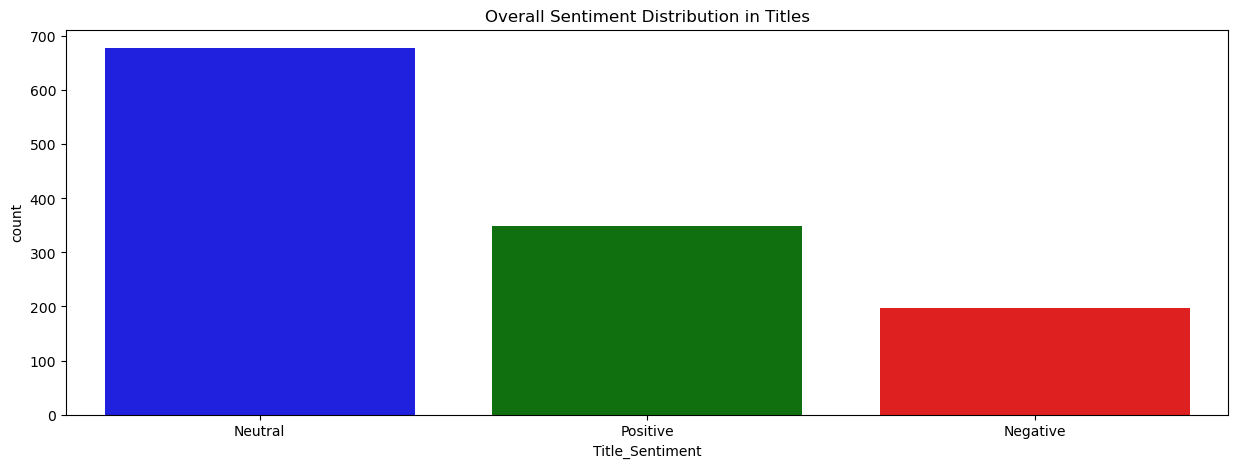

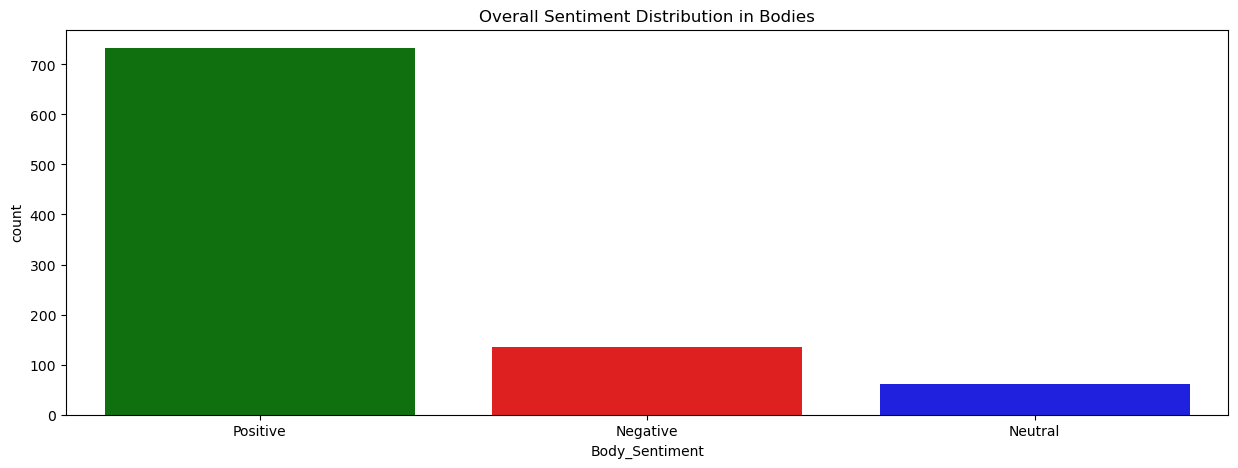

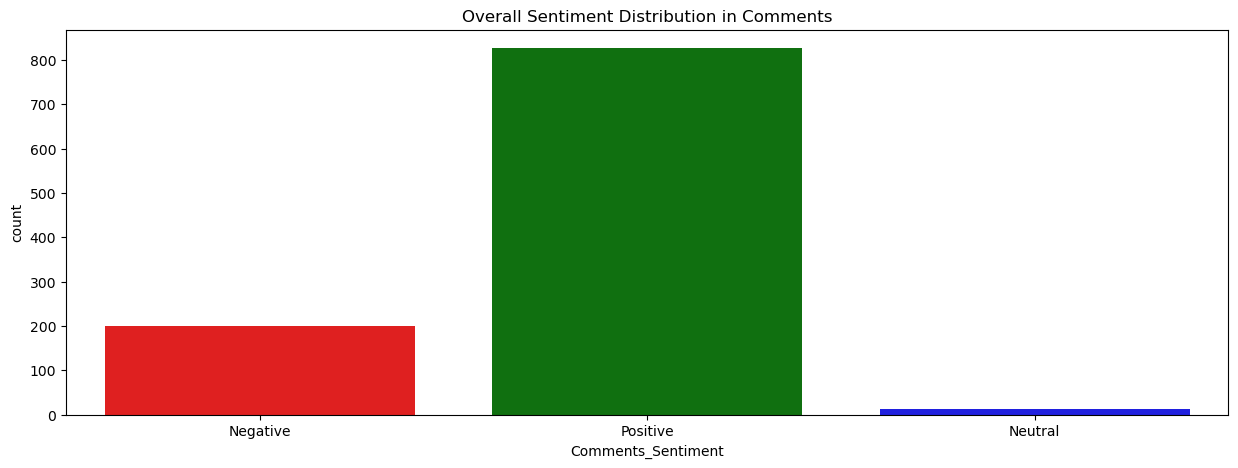

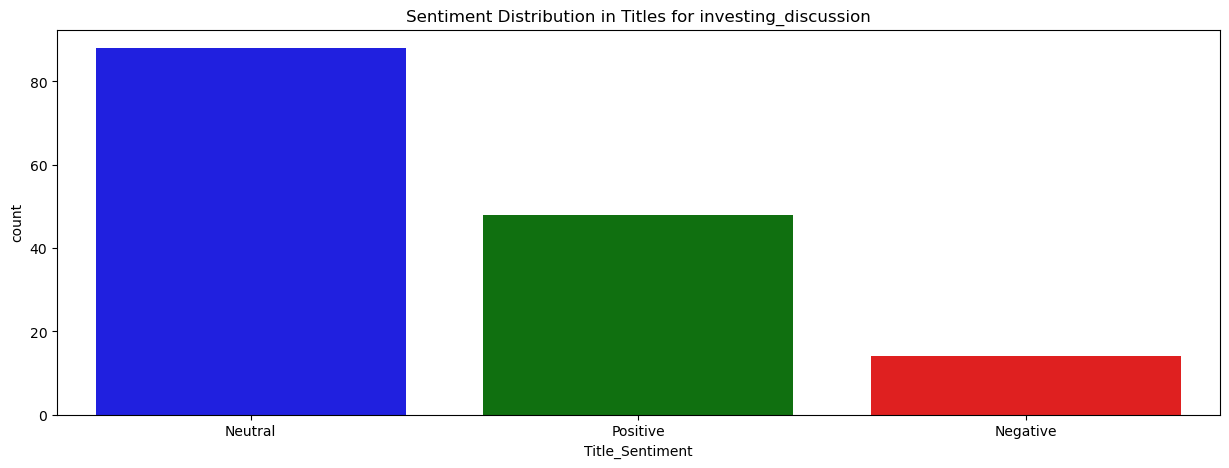

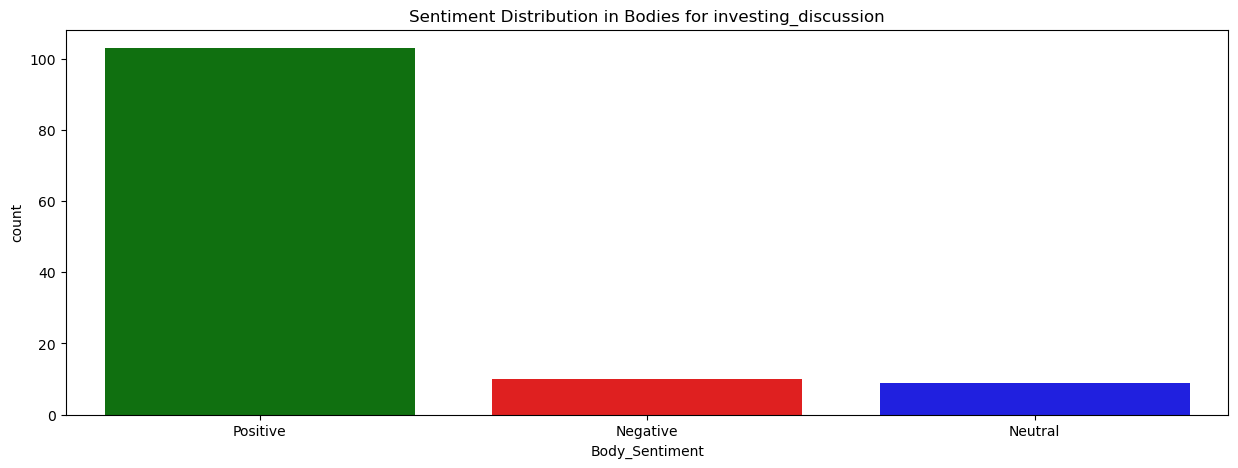

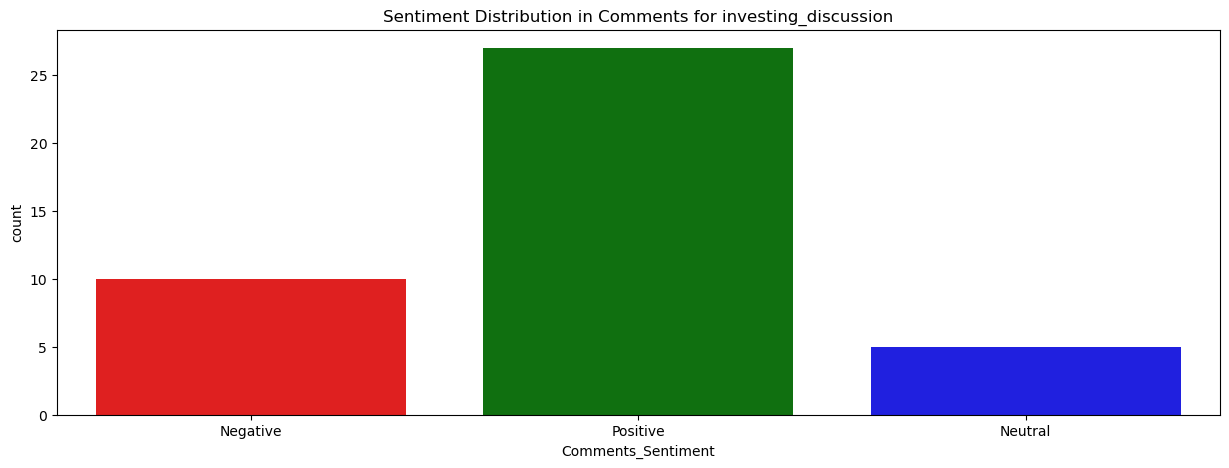

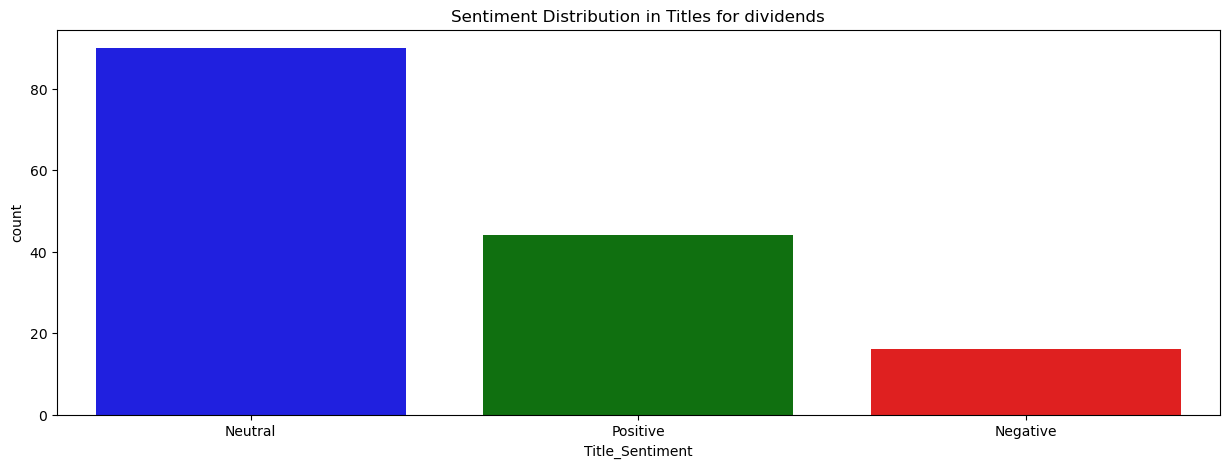

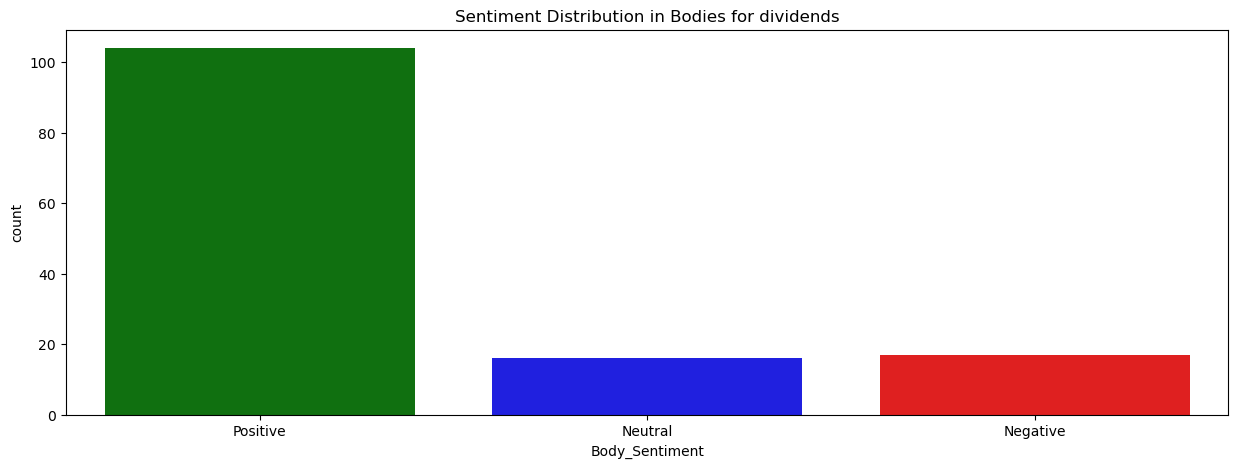

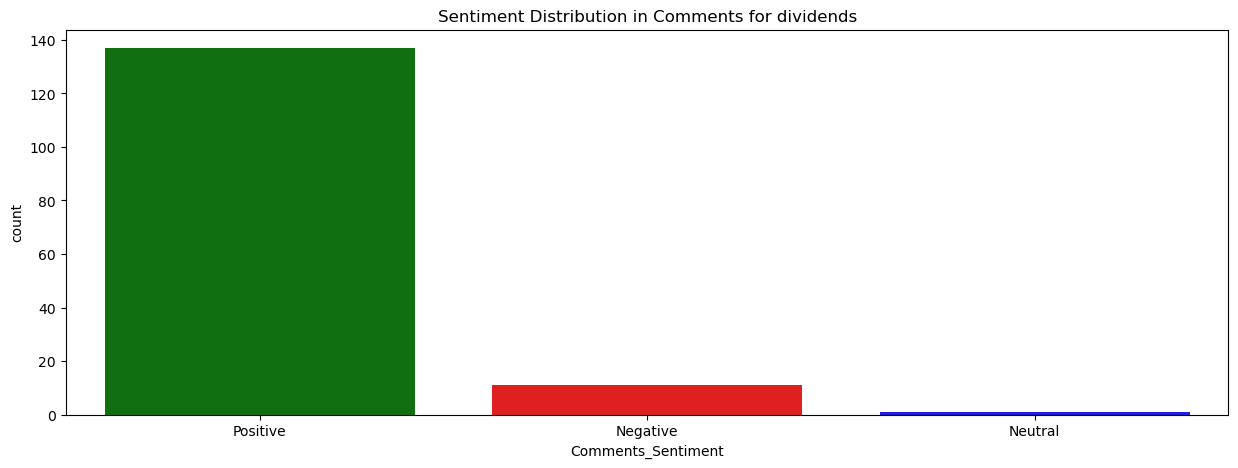

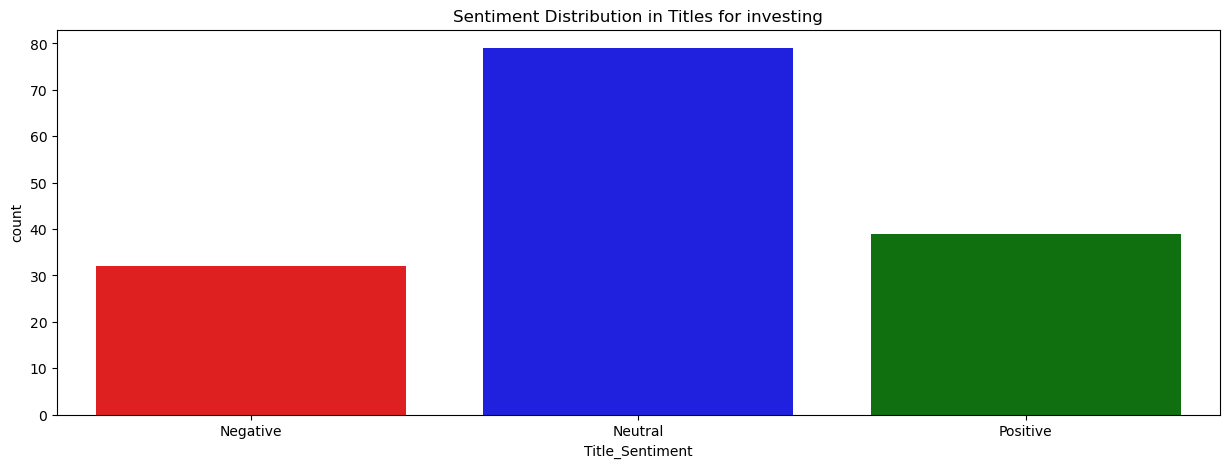

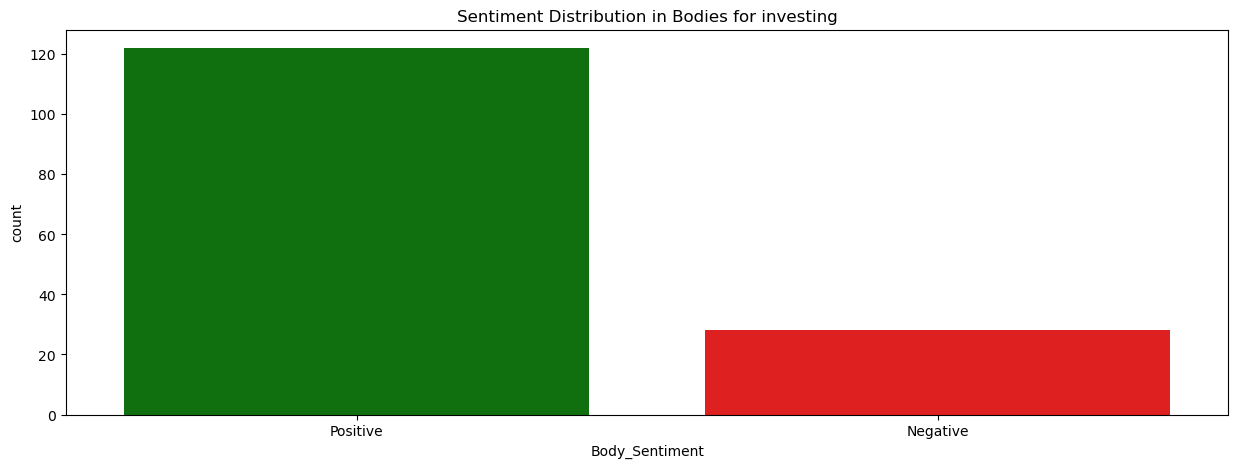

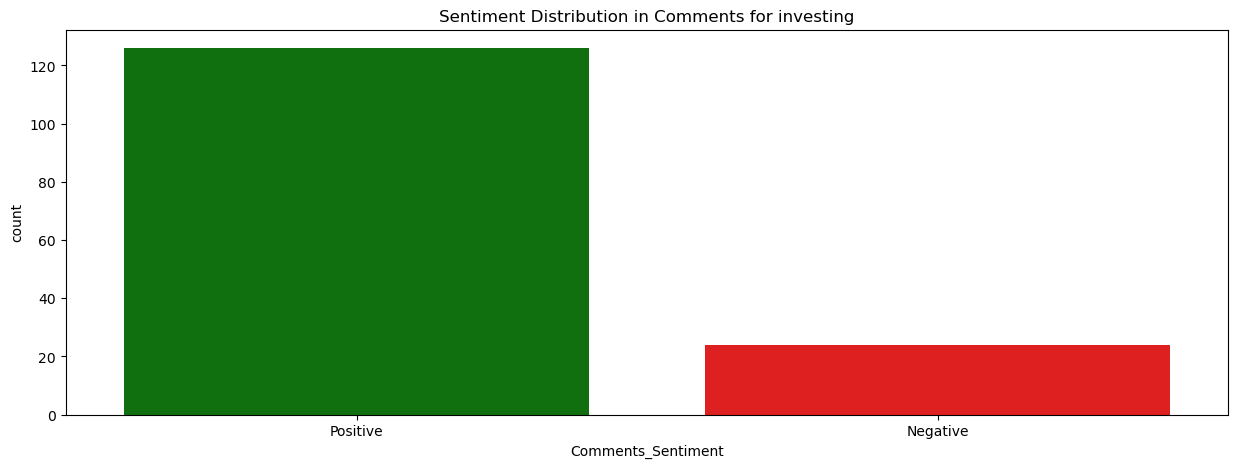

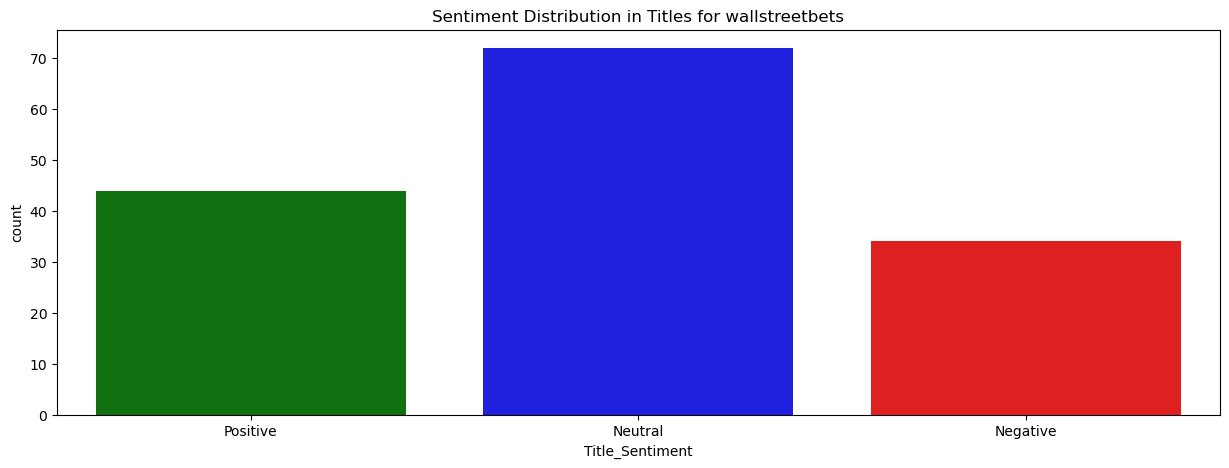

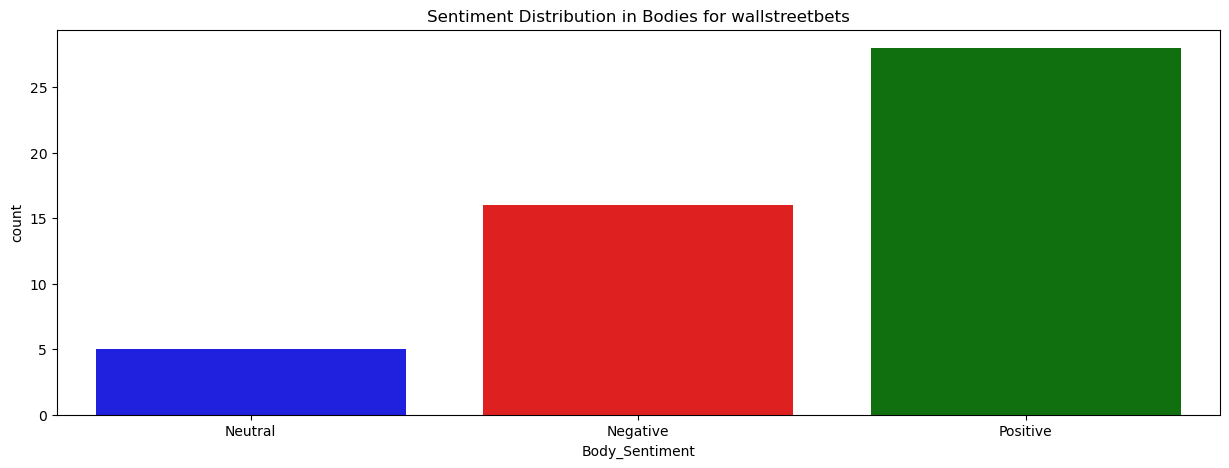

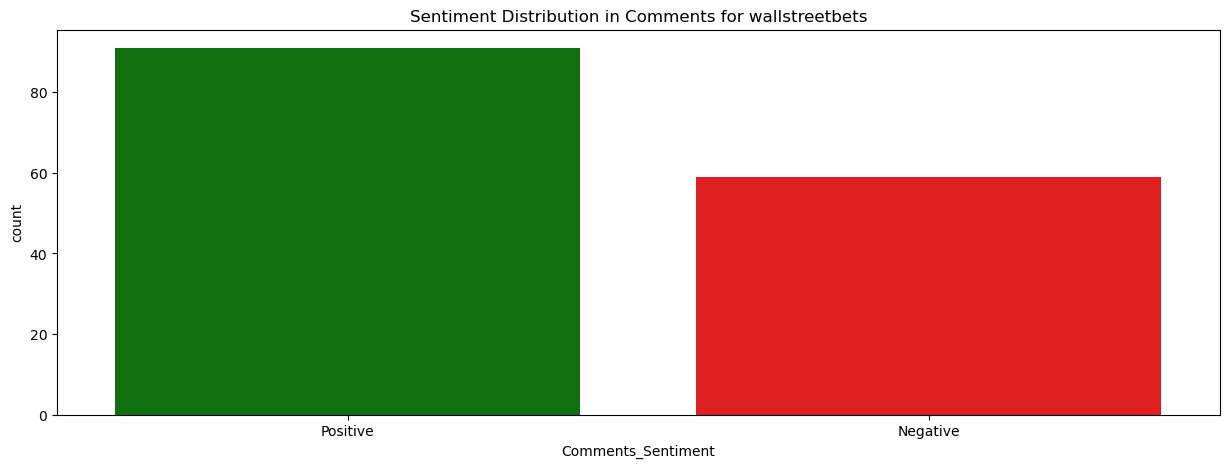

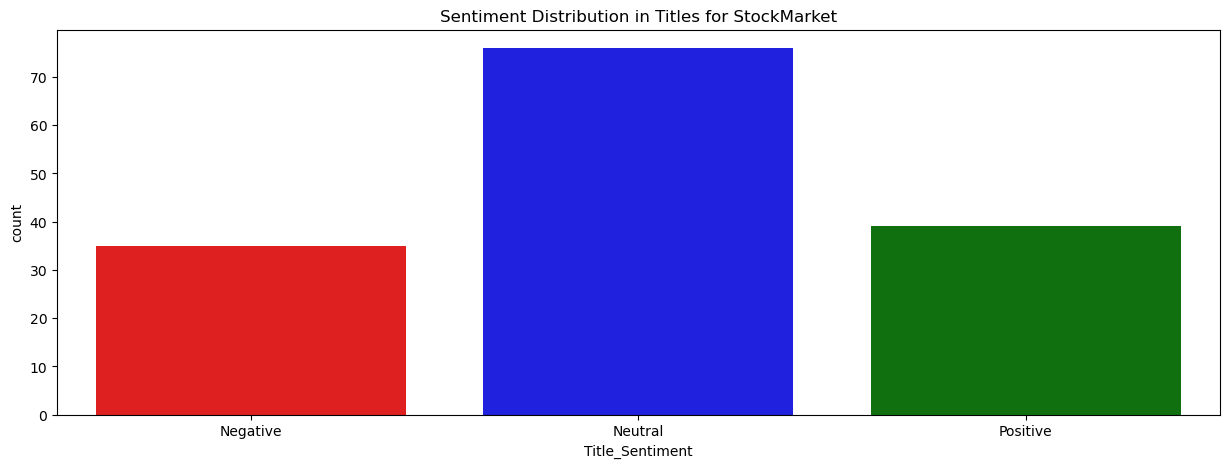

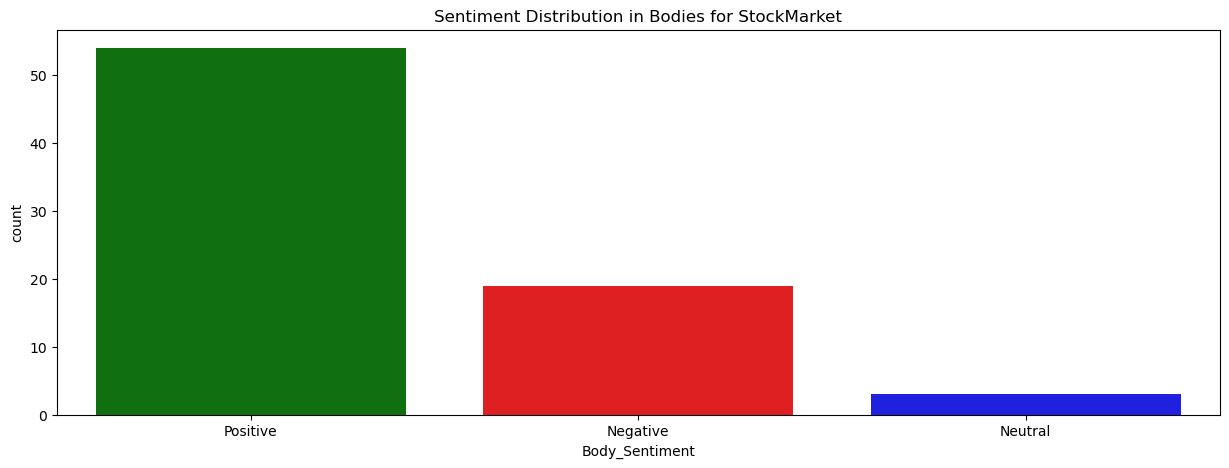

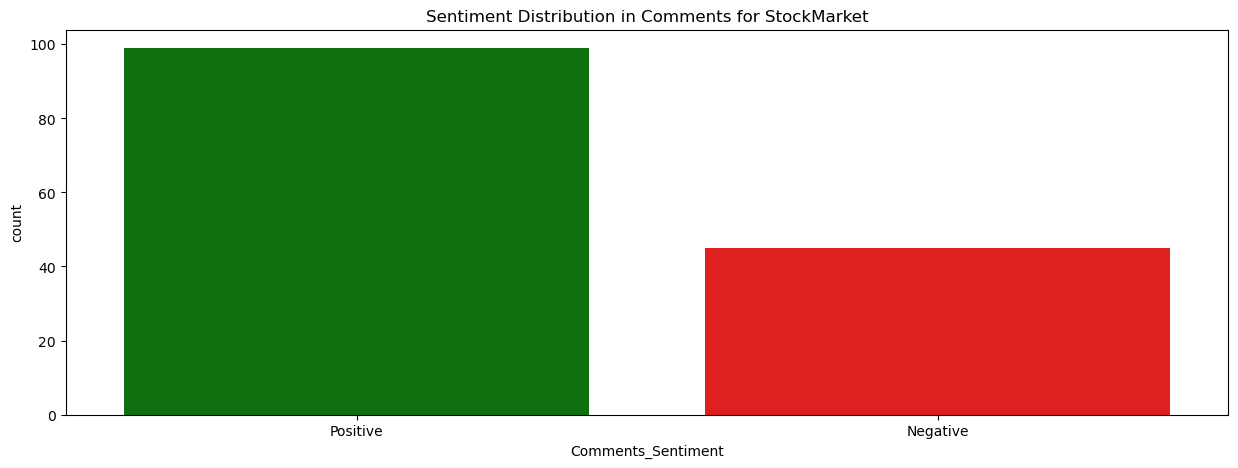

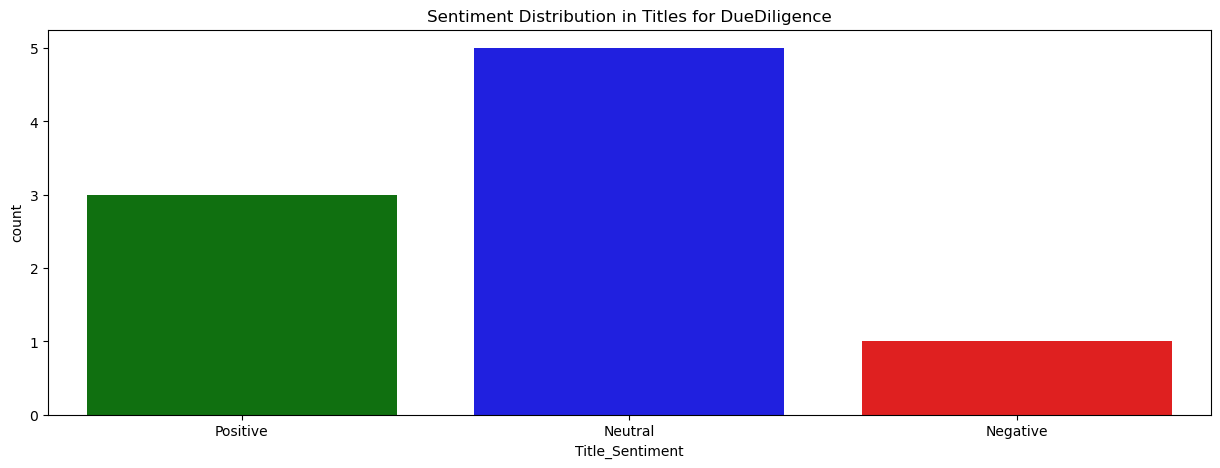

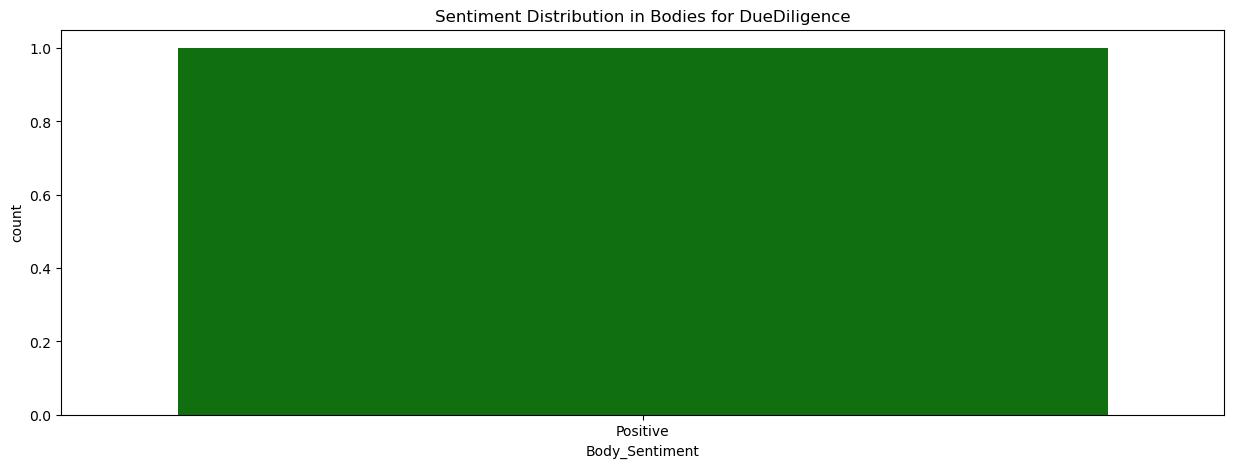

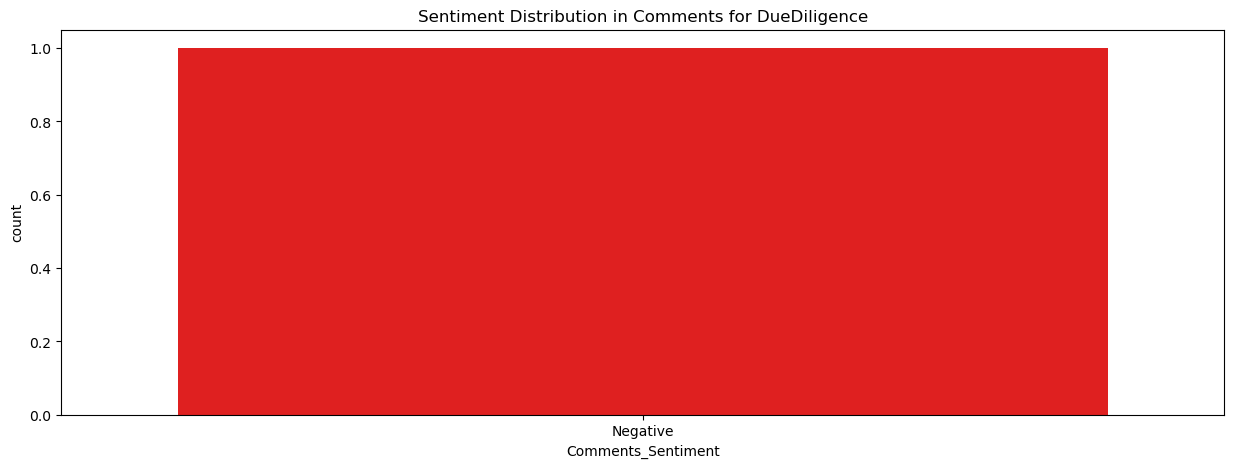

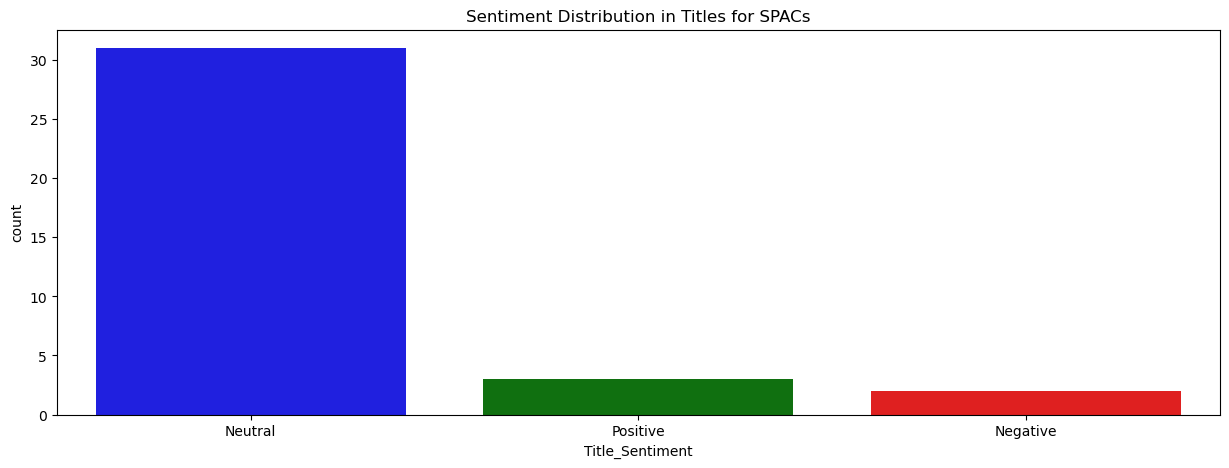

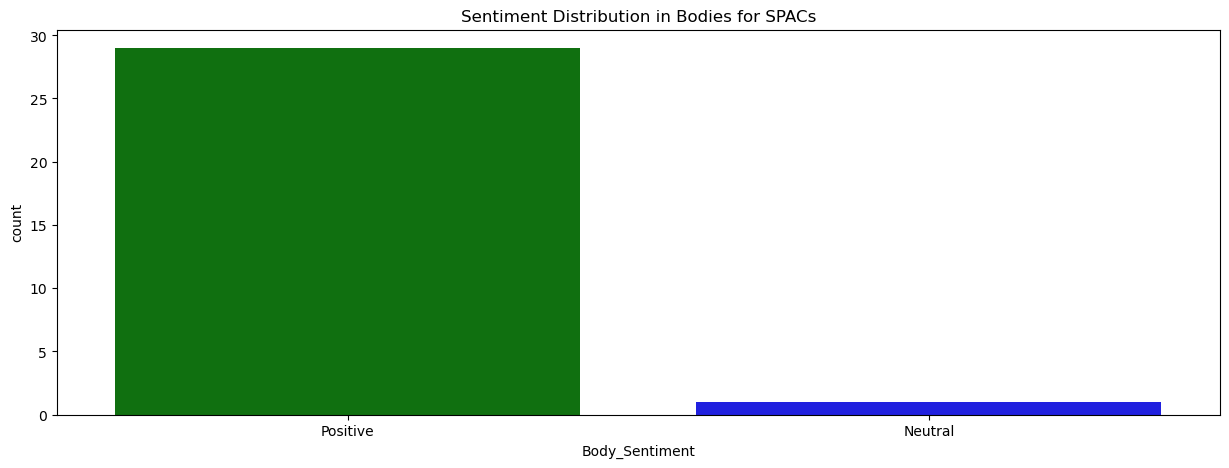

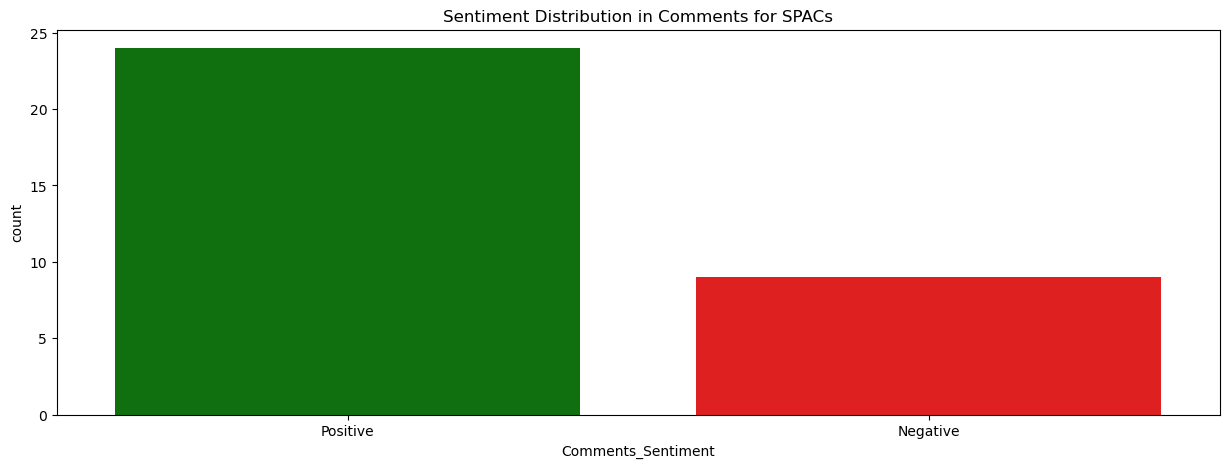

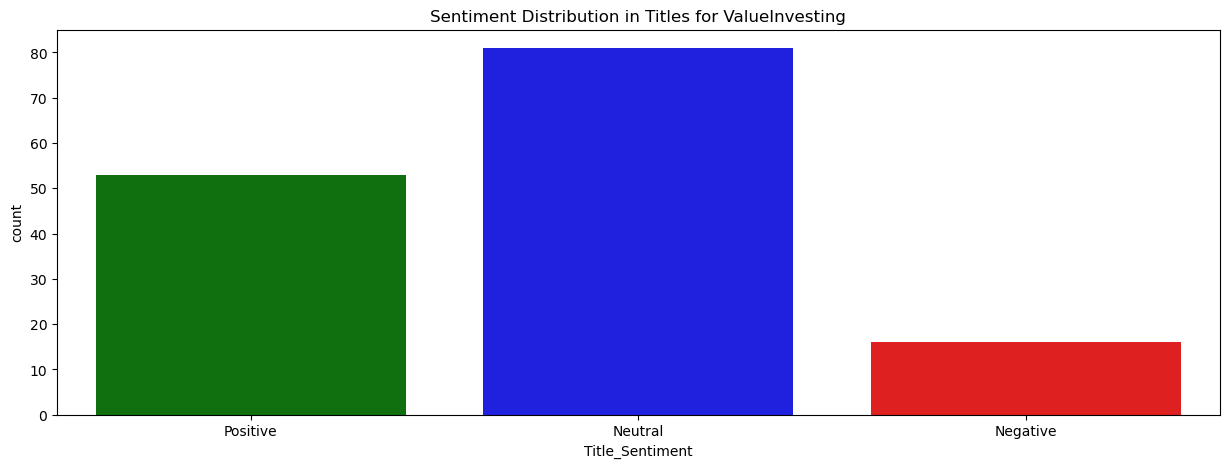

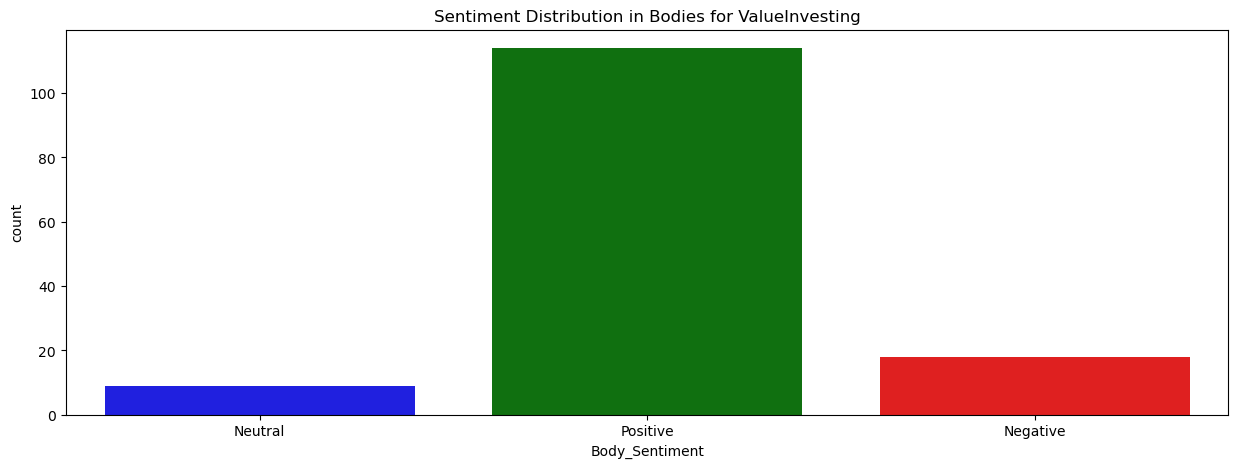

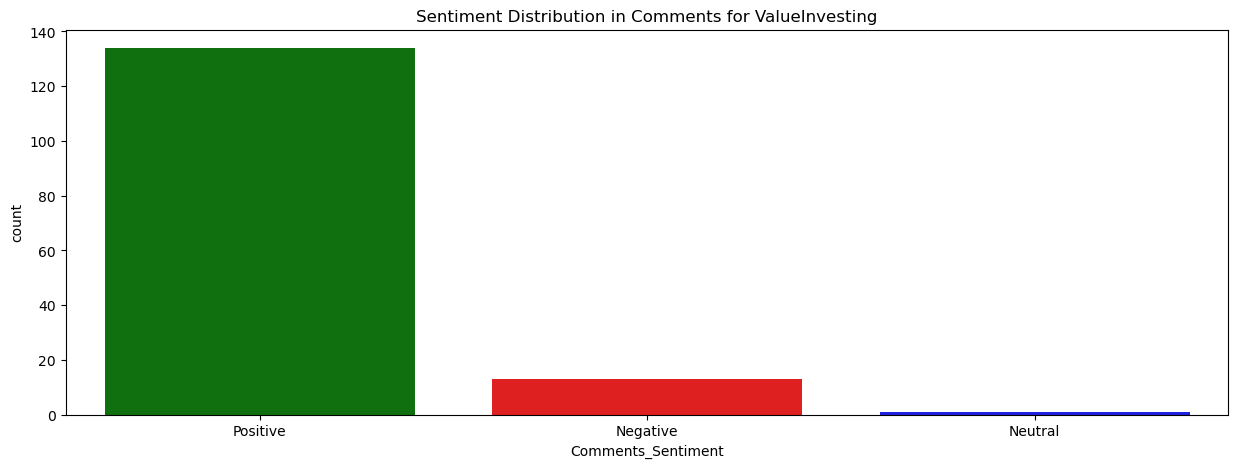

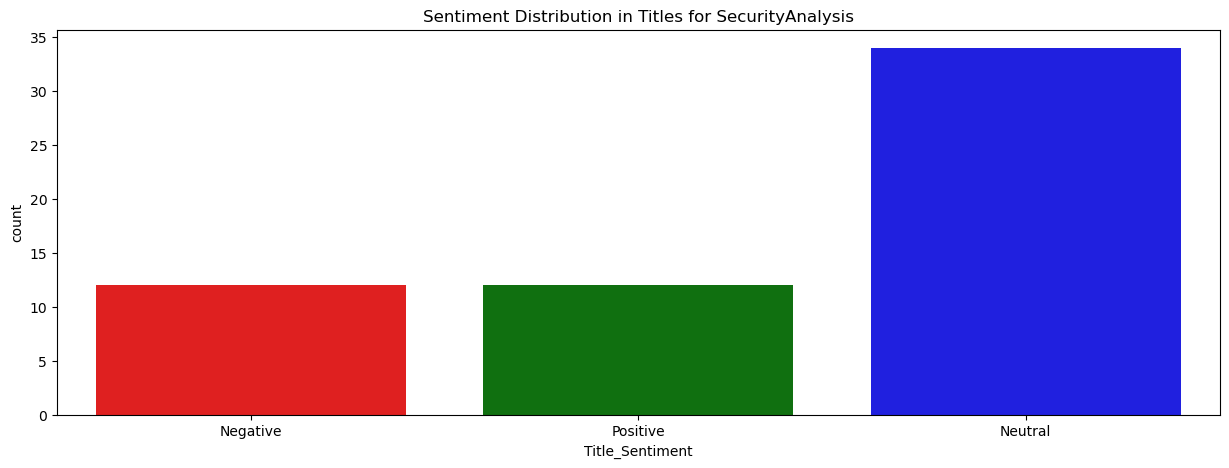

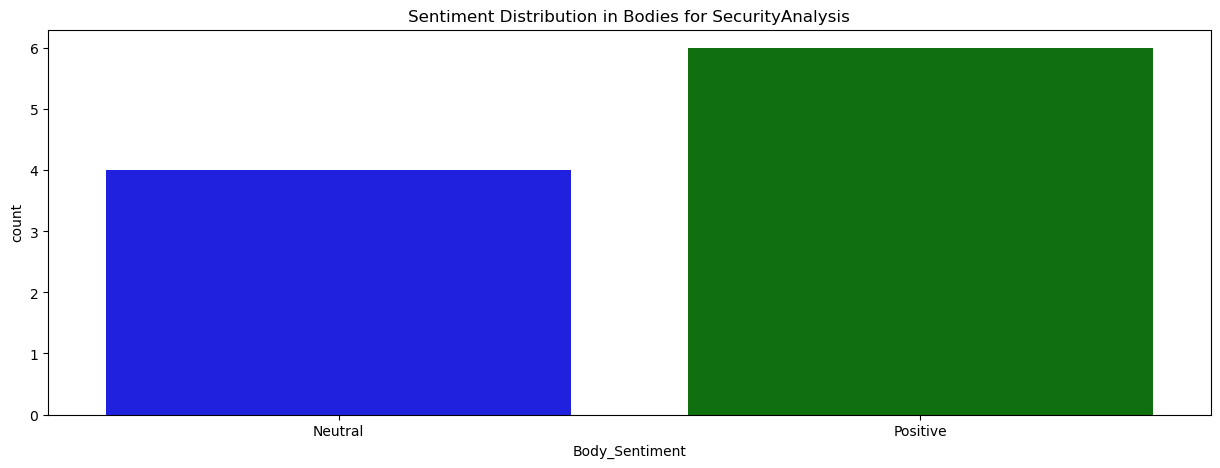

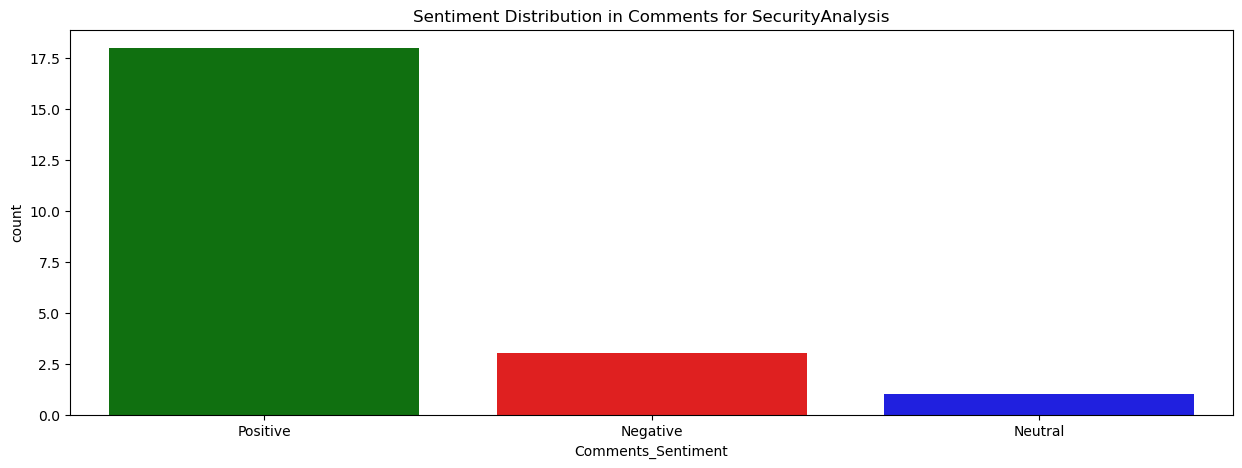

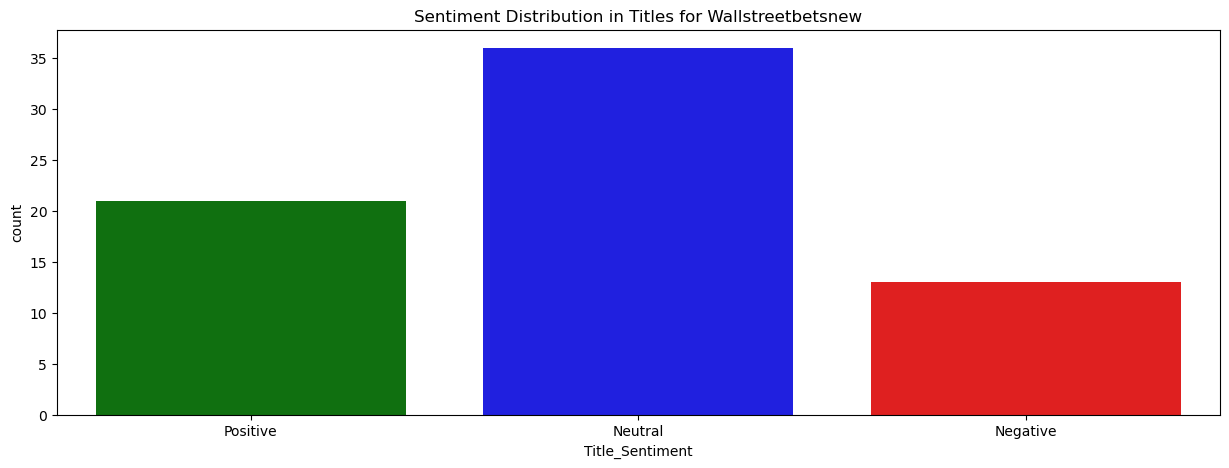

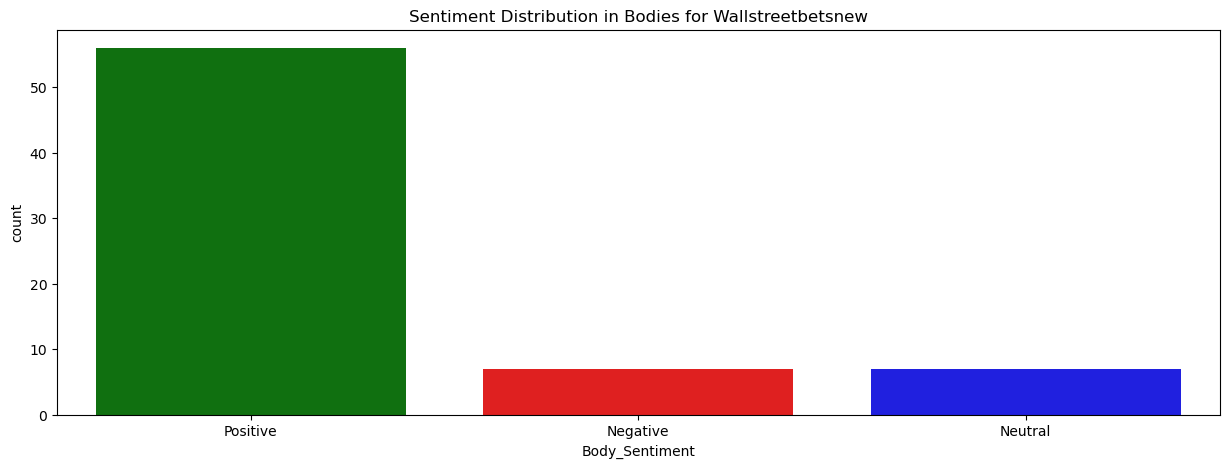

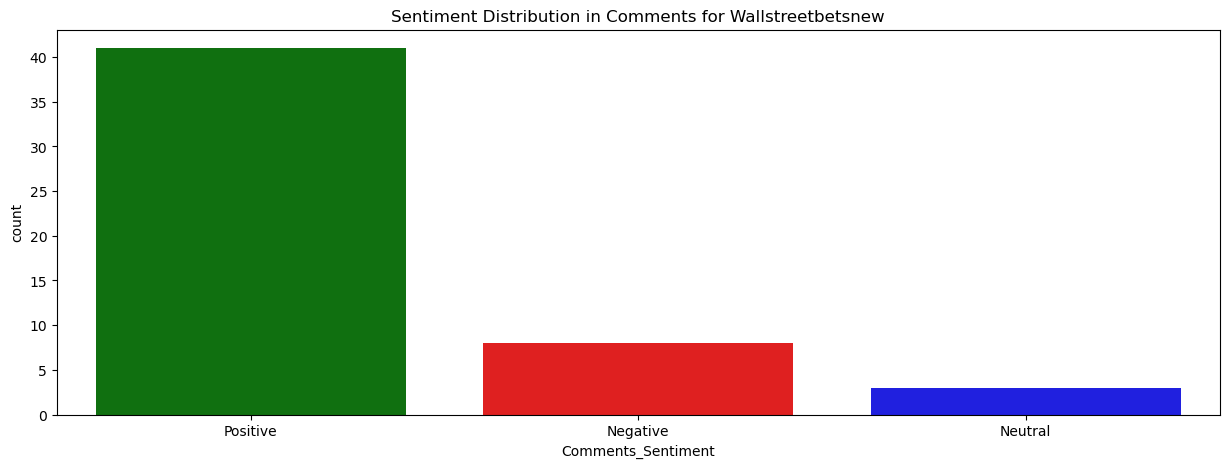

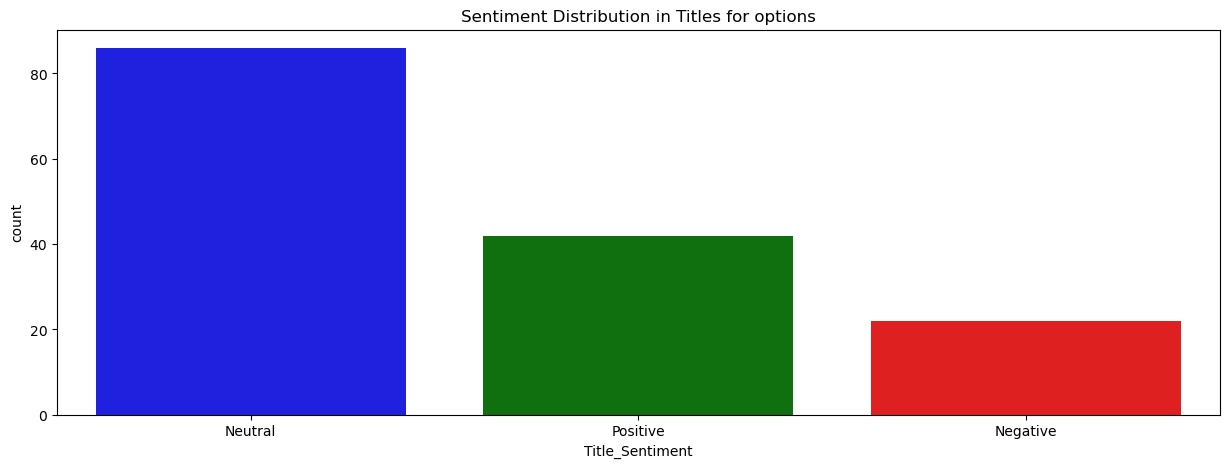

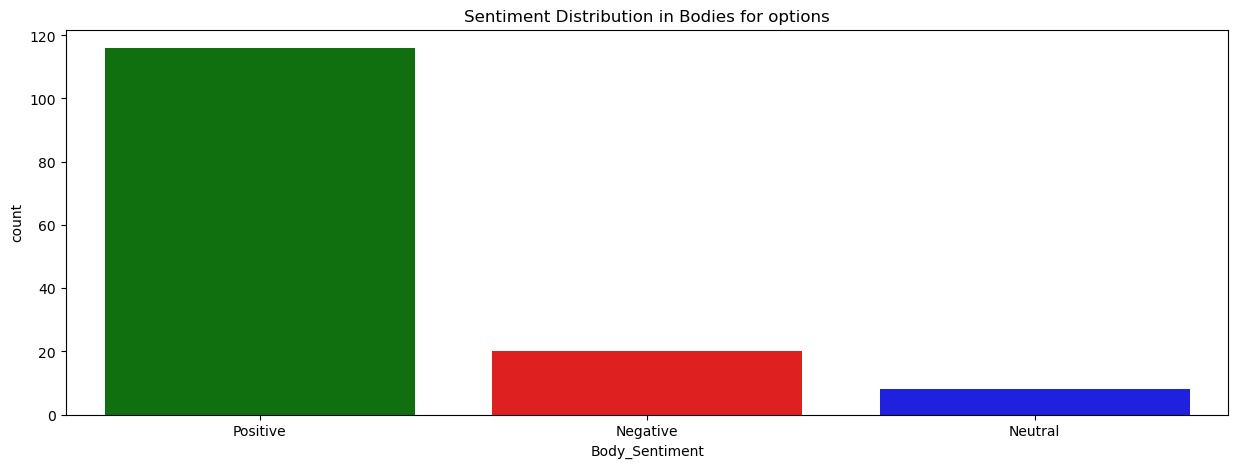

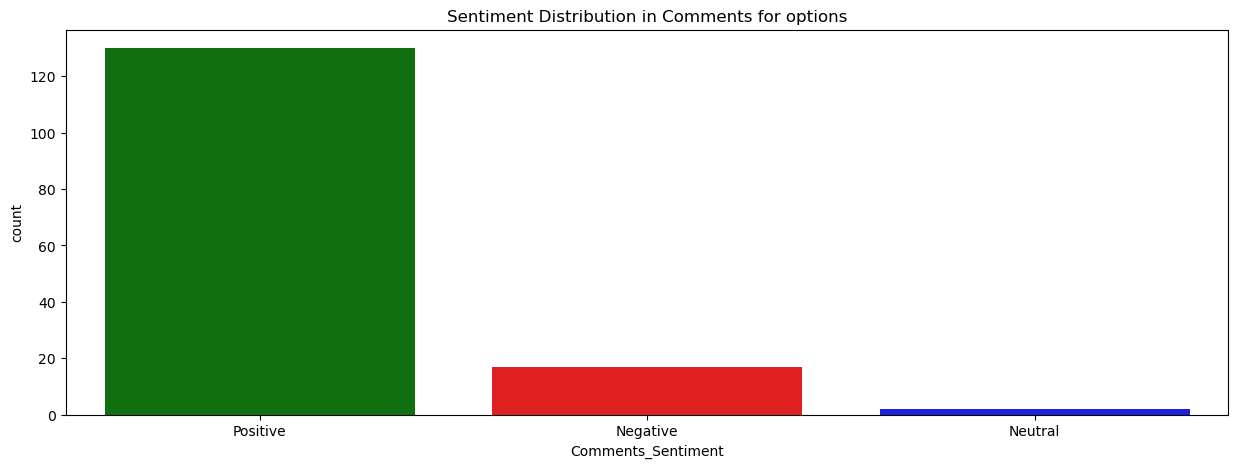

In [289]:
import pandas as pd
import nltk
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

df = pd.read_csv("reddit_stock_comments_cleaned.csv")

sia = SentimentIntensityAnalyzer()

def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# this function get sentiments scores
def get_vader_sentiment(text):
    if pd.isna(text):
        return None
    else:
        return classify_sentiment(sia.polarity_scores(str(text))['compound'])

# here I am adding sentiment columns for Title, Body, and Comments
df['Title_Sentiment'] = df['Title'].apply(get_vader_sentiment)
df['Body_Sentiment'] = df['Body'].apply(get_vader_sentiment)
df['Comments_Sentiment'] = df['Comments'].apply(lambda x: get_vader_sentiment(x) if x != '[]' else None)

# defining the color palette
palette = {'Positive': 'green', 'Neutral': 'blue', 'Negative': 'red'}

# plots to show overall sentiment distribution
plt.figure(figsize=(15,5))
sns.countplot(data=df, x='Title_Sentiment', palette=palette)
plt.title("Overall Sentiment Distribution in Titles")
plt.show()

plt.figure(figsize=(15,5))
sns.countplot(data=df, x='Body_Sentiment', palette=palette)
plt.title("Overall Sentiment Distribution in Bodies")
plt.show()

plt.figure(figsize=(15,5))
sns.countplot(data=df, x='Comments_Sentiment', palette=palette)
plt.title("Overall Sentiment Distribution in Comments")
plt.show()

# this part is to show the sentiment distribution by subreddit post title, body, and comments
subreddits = df['Subreddit'].unique()

for subreddit in subreddits:
    temp_df = df[df['Subreddit'] == subreddit]
    
    plt.figure(figsize=(15,5))
    sns.countplot(data=temp_df, x='Title_Sentiment', palette=palette)
    plt.title(f"Sentiment Distribution in Titles for {subreddit}")
    plt.show()

    plt.figure(figsize=(15,5))
    sns.countplot(data=temp_df, x='Body_Sentiment', palette=palette)
    plt.title(f"Sentiment Distribution in Bodies for {subreddit}")
    plt.show()

    plt.figure(figsize=(15,5))
    sns.countplot(data=temp_df, x='Comments_Sentiment', palette=palette)
    plt.title(f"Sentiment Distribution in Comments for {subreddit}")
    plt.show()


Words Most Positively Correlated with Positive Sentiment:
like       0.042297
company    0.042165
market     0.042112
stock      0.040704
just       0.040025
https      0.036078
money      0.035537
buy        0.033929
com        0.033295
good       0.030796
years      0.029959
growth     0.029779
price      0.028953
time       0.028397
don        0.028101
year       0.027179
options    0.026824
stocks     0.026633
shares     0.026374
long       0.025863
dtype: float64


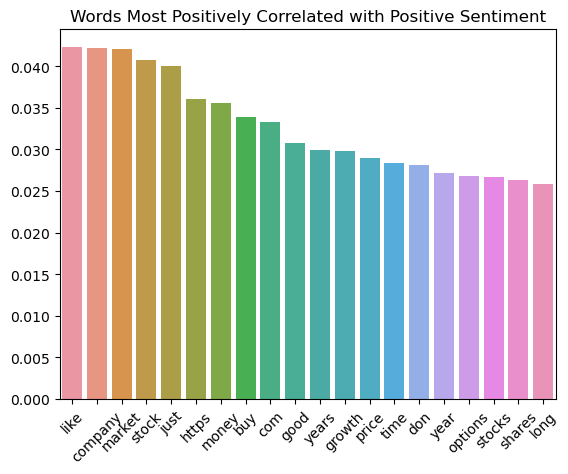

Words Most Positively Correlated with Negative Sentiment:
market    0.047317
just      0.047221
money     0.036177
people    0.034575
stock     0.033656
time      0.032246
china     0.031508
don       0.030958
shit      0.030766
buy       0.028947
bad       0.028938
like      0.028007
know      0.027689
years     0.027688
good      0.027568
calls     0.026606
puts      0.026340
stocks    0.025477
year      0.025216
https     0.024758
dtype: float64


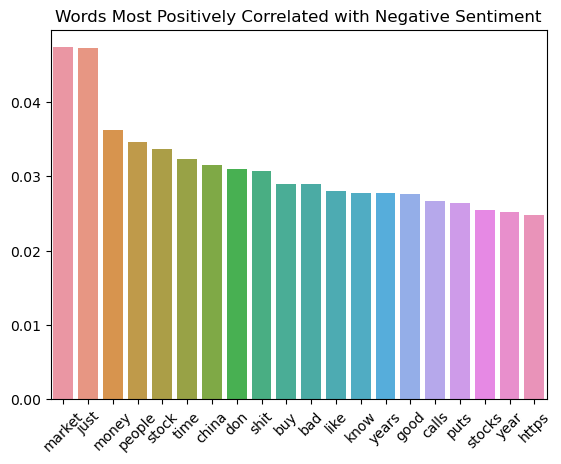

Words Most Positively Correlated with Neutral Sentiment:
stock        0.108872
earnings     0.099835
https        0.055837
nvidia       0.046227
nvda         0.043682
23           0.041623
tech         0.039974
2023         0.031442
app          0.027678
invest       0.025028
week         0.023982
weekly       0.023287
www          0.022791
investor     0.022222
cloud        0.022222
history      0.022222
thinking     0.022222
net          0.022222
paid         0.022222
potential    0.021093
dtype: float64


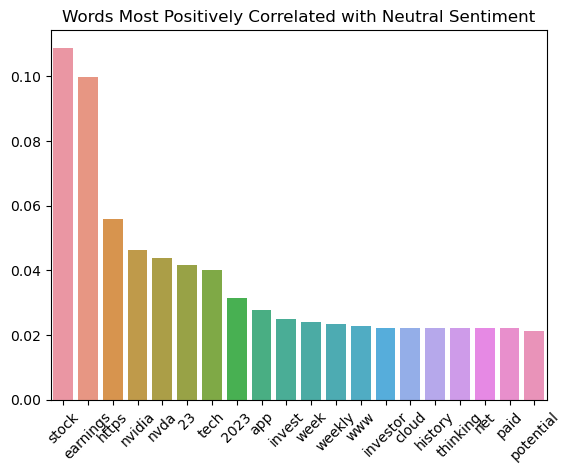

In [290]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

df = pd.read_csv('reddit_stock_comments_cleaned.csv')

# fills NaN with empty strings
df.fillna("", inplace=True)

# this combines Title, Body, and Comments for a complete text
df['Complete_Text'] = df['Title'] + ' ' + df['Body'] + ' ' + df['Comments'].apply(str)

# Initializing the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# function to classify sentiment
def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# function to get all the sentiment scores
def get_vader_sentiment(text):
    return classify_sentiment(sia.polarity_scores(text)['compound'])

# assigning sentiment to the text
df['Sentiment'] = df['Complete_Text'].apply(get_vader_sentiment)

# this performs a TF-IDF Vectorization for sentiment analysis
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_result = tfidf.fit_transform(df['Complete_Text']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf.get_feature_names_out())
tfidf_df['Sentiment'] = df['Sentiment']

# this portion we find words that are most positively correlated with each sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    temp_df = tfidf_df[tfidf_df['Sentiment'] == sentiment]
    mean_scores = temp_df.drop('Sentiment', axis=1).mean()
    print(f"Words Most Positively Correlated with {sentiment} Sentiment:")
    print(mean_scores.sort_values(ascending=False).head(20))
    sns.barplot(x=mean_scores.sort_values(ascending=False).head(20).index, 
                y=mean_scores.sort_values(ascending=False).head(20))
    plt.title(f"Words Most Positively Correlated with {sentiment} Sentiment")
    plt.xticks(rotation=45)
    plt.show()


Words Most Positively Correlated with Positive Sentiment:


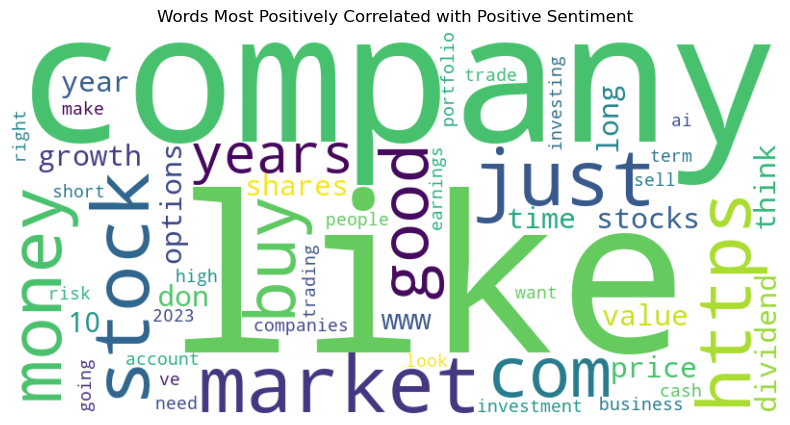

Words Most Positively Correlated with Negative Sentiment:


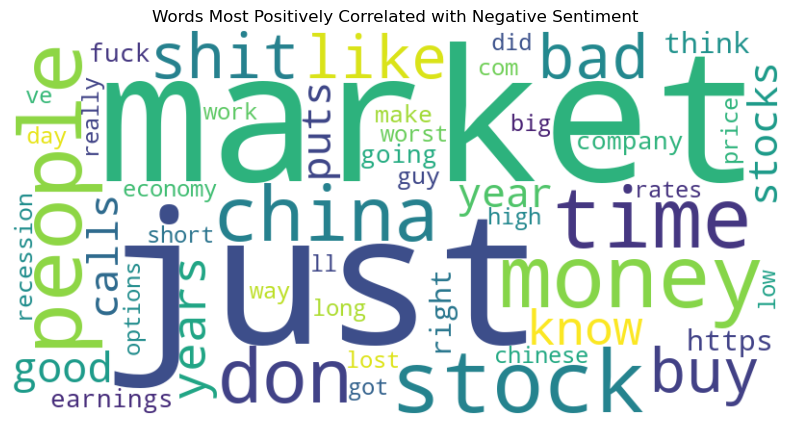

Words Most Positively Correlated with Neutral Sentiment:


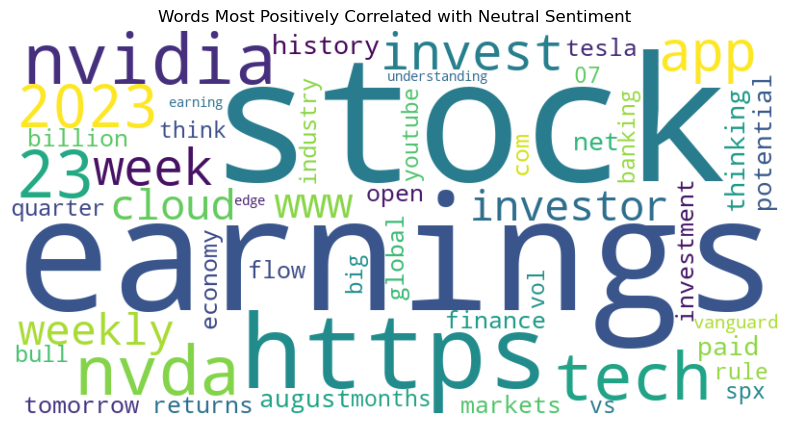

In [291]:
#this is the same code snippet as above except that we are actually displaying a word cloud instead
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

df = pd.read_csv('reddit_stock_comments_cleaned.csv')

df.fillna("", inplace=True)

df['Complete_Text'] = df['Title'] + ' ' + df['Body'] + ' ' + df['Comments'].apply(str)

sia = SentimentIntensityAnalyzer()

def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

def get_vader_sentiment(text):
    return classify_sentiment(sia.polarity_scores(text)['compound'])

df['Sentiment'] = df['Complete_Text'].apply(get_vader_sentiment)

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_result = tfidf.fit_transform(df['Complete_Text']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf.get_feature_names_out())
tfidf_df['Sentiment'] = df['Sentiment']

for sentiment in ['Positive', 'Negative', 'Neutral']:
    temp_df = tfidf_df[tfidf_df['Sentiment'] == sentiment]
    mean_scores = temp_df.drop('Sentiment', axis=1).mean()
    
    print(f"Words Most Positively Correlated with {sentiment} Sentiment:")
    
    # here we are createing a word cloud
    wordcloud_dict = mean_scores.sort_values(ascending=False).head(50).to_dict()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)
    
    # here is how we display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Words Most Positively Correlated with {sentiment} Sentiment")
    plt.show()


[nltk_data] Downloading package punkt to /Users/amayiyer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amayiyer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Entities Most Positively Correlated with Positive Sentiment:
[('*', 2923), ('’', 1041), ('|', 735), (']', 597), ('[', 510), ('US', 233), ('=', 227), ('IRA', 205), ('Roth', 194), ('IV', 186)]


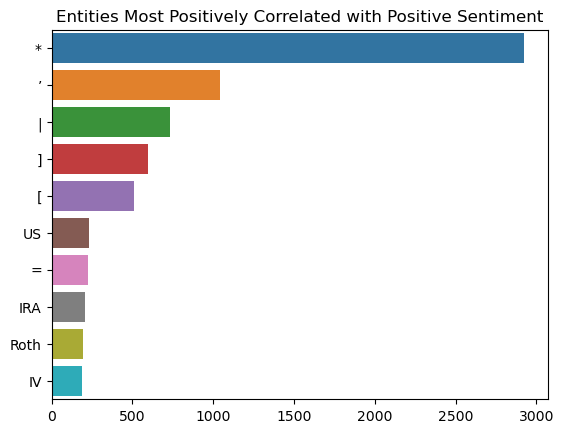

Entities Most Positively Correlated with Negative Sentiment:
[('’', 176), ('*', 115), ('[', 82), (']', 51), ('China', 49), ('US', 41), ('P', 27), ('Roth', 27), ('S', 26), ('”', 25)]


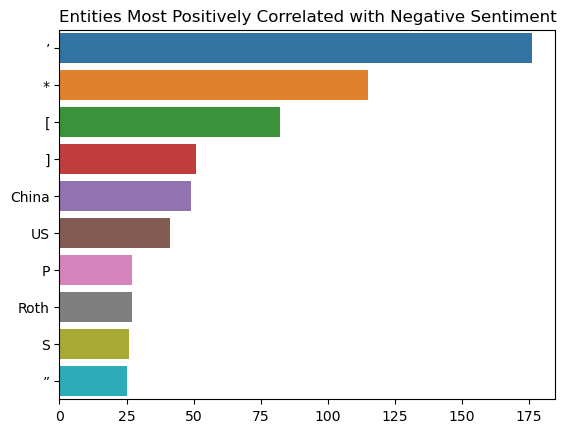

Entities Most Positively Correlated with Neutral Sentiment:
[('[', 20), ('Earnings', 3), ('NVDA', 3), ('NVIDIA', 3), ('Bitcoin', 3), ('Recap', 2), ('SOFI', 2), ('DASH', 2), ('DoorDash', 2), ('Open', 2)]


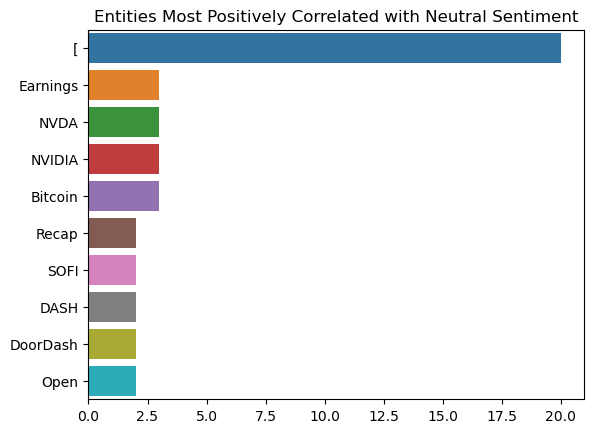

In [292]:
import pandas as pd
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# downloading the Punkt tokenizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv('reddit_stock_comments_cleaned.csv')

df.fillna("", inplace=True)

df['Complete_Text'] = df['Title'] + ' ' + df['Body'] + ' ' + df['Comments'].apply(str)

sia = SentimentIntensityAnalyzer()

def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

def get_vader_sentiment(text):
    return classify_sentiment(sia.polarity_scores(text)['compound'])

df['Sentiment'] = df['Complete_Text'].apply(get_vader_sentiment)

def extract_entities(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    named_entities = [word for word, pos in pos_tags if pos == 'NNP']
    return named_entities

df['Entities'] = df['Complete_Text'].apply(extract_entities)

entity_sentiment = {'Positive': Counter(), 'Negative': Counter(), 'Neutral': Counter()}

for _, row in df.iterrows():
    entity_sentiment[row['Sentiment']].update(row['Entities'])

for sentiment, counter in entity_sentiment.items():
    print(f"Entities Most Positively Correlated with {sentiment} Sentiment:")
    common_entities = counter.most_common(10)
    print(common_entities)

    if common_entities:  
        entities, counts = zip(*common_entities)
        sns.barplot(y=list(entities), x=list(counts))
        plt.title(f"Entities Most Positively Correlated with {sentiment} Sentiment")
        plt.show()


In [293]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


Entities Most Positively Correlated with Positive Sentiment:
[('US', 233), ('IRA', 205), ('Roth', 194), ('IV', 186), ('S', 176), ('AI', 162), ('VOO', 162), ('Amazon', 158), ('SCHD', 146), ('SPY', 139), ('O', 138), ('Apple', 137), ('P', 137), ('ETFs', 131), ('QQQ', 129), ('ETF', 128), ('August', 121), ('JEPI', 119), ('June', 118), ('Just', 102), ('AND', 102), ('A', 101), ('VTI', 97), ('SPX', 90), ('China', 89), ('EBITDA', 89), ('PE', 87), ('Stock', 85), ('CEO', 83), ('Company', 80)]


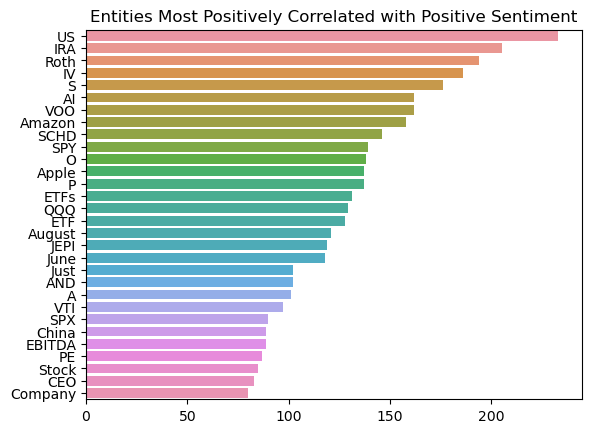

Entities Most Positively Correlated with Negative Sentiment:
[('China', 49), ('US', 41), ('P', 27), ('Roth', 27), ('S', 26), ('SPY', 20), ('Fed', 18), ('July', 16), ('IV', 15), ('T', 13), ('IRA', 13), ('NVDA', 13), ('Tesla', 13), ('USA', 12), ('Burry', 12), ('Cleveland', 11), ('A', 11), ('WSB', 11), ('CEO', 10), ('Market', 10), ('AI', 9), ('Evergrande', 9), ('CCP', 9), ('PE', 9), ('Index', 9), ('Cramer', 9), ('Apple', 8), ('Just', 8), ('CPI', 8), ('VOO', 8)]


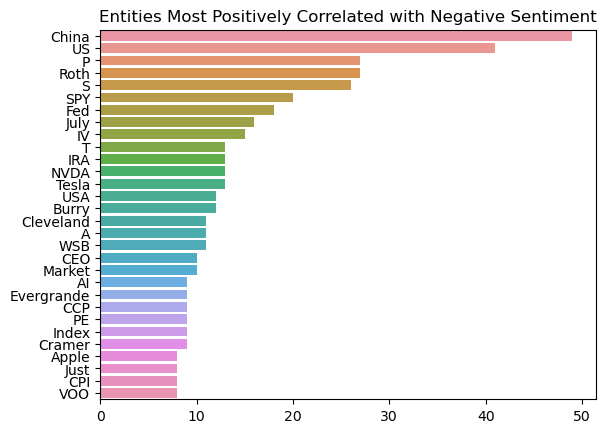

Entities Most Positively Correlated with Neutral Sentiment:
[('Earnings', 3), ('NVDA', 3), ('NVIDIA', 3), ('Bitcoin', 3), ('Recap', 2), ('SOFI', 2), ('DASH', 2), ('DoorDash', 2), ('Open', 2), ('Blockchain', 2), ('Edition', 2), ('PDF', 2), ('Vanguard', 2), ('Overview', 2), ('Review', 2), ('Baidu', 1), ('Call', 1), ('Summary', 1), ('Lido', 1), ('Finance', 1), ('SPX', 1), ('Pops', 1), ('Drops', 1), ('VOL', 1), ('Sellers', 1), ('VIX', 1), ('Ora', 1), ('Carbon', 1), ('Tomorrow', 1), ('Leverage', 1)]


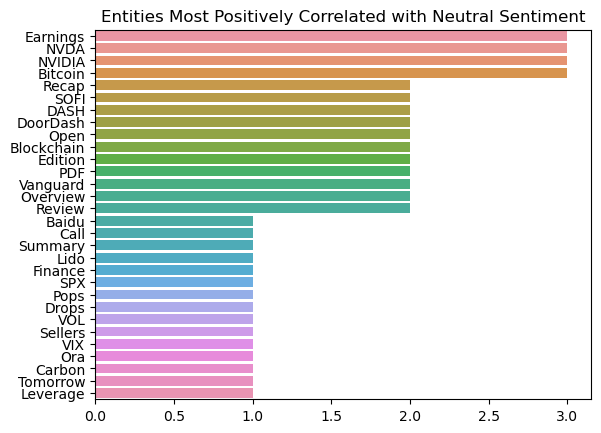

In [294]:
#in this portion, i am cleaning the dataframe to omit the special characters from an entity-based sentiment analysis

import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

def extract_entities(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    named_entities = [word for word, pos in pos_tags if pos == 'NNP' and word.isalpha()]
    return named_entities

df = pd.read_csv('reddit_stock_comments_cleaned.csv')

df.fillna("", inplace=True)

df['Complete_Text'] = df['Title'] + ' ' + df['Body'] + ' ' + df['Comments'].apply(str)

sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    return classify_sentiment(sia.polarity_scores(text)['compound'])

df['Sentiment'] = df['Complete_Text'].apply(get_vader_sentiment)

df['Entities'] = df['Complete_Text'].apply(extract_entities)

for sentiment in ['Positive', 'Negative', 'Neutral']:
    common_entities = Counter([entity for index, row in df[df['Sentiment'] == sentiment].iterrows() for entity in row['Entities']]).most_common(30)
    
    print(f"Entities Most Positively Correlated with {sentiment} Sentiment:")
    print(common_entities)
    
    entities, counts = zip(*common_entities)
    sns.barplot(x=list(counts), y=list(entities))
    plt.title(f"Entities Most Positively Correlated with {sentiment} Sentiment")
    plt.show()


Entities Most Positively Correlated with Positive Sentiment by VADER:
[('US', 233), ('IRA', 205), ('Roth', 194), ('IV', 186), ('S', 176), ('AI', 162), ('VOO', 162), ('Amazon', 158), ('SCHD', 146), ('SPY', 139), ('O', 138), ('Apple', 137), ('P', 137), ('ETFs', 131), ('QQQ', 129), ('ETF', 128), ('August', 121), ('JEPI', 119), ('June', 118), ('Just', 102), ('AND', 102), ('A', 101), ('VTI', 97), ('SPX', 90), ('China', 89), ('EBITDA', 89), ('PE', 87), ('Stock', 85), ('CEO', 83), ('Company', 80)]


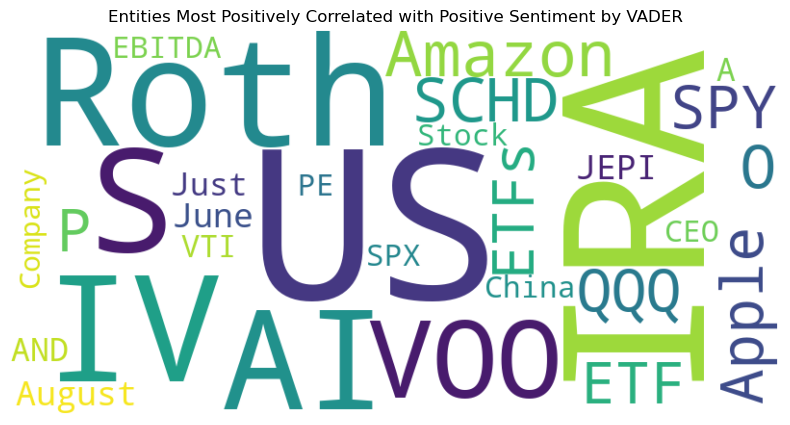

Entities Most Positively Correlated with Negative Sentiment by VADER:
[('China', 49), ('US', 41), ('P', 27), ('Roth', 27), ('S', 26), ('SPY', 20), ('Fed', 18), ('July', 16), ('IV', 15), ('T', 13), ('IRA', 13), ('NVDA', 13), ('Tesla', 13), ('USA', 12), ('Burry', 12), ('Cleveland', 11), ('A', 11), ('WSB', 11), ('CEO', 10), ('Market', 10), ('AI', 9), ('Evergrande', 9), ('CCP', 9), ('PE', 9), ('Index', 9), ('Cramer', 9), ('Apple', 8), ('Just', 8), ('CPI', 8), ('VOO', 8)]


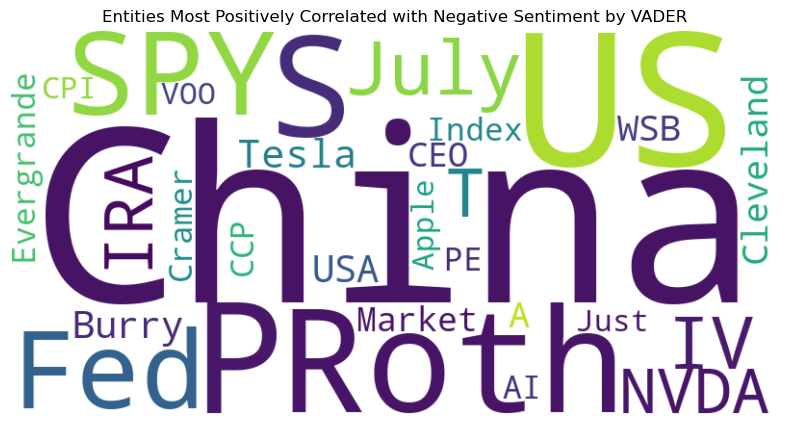

Entities Most Positively Correlated with Neutral Sentiment by VADER:
[('Earnings', 3), ('NVDA', 3), ('NVIDIA', 3), ('Bitcoin', 3), ('Recap', 2), ('SOFI', 2), ('DASH', 2), ('DoorDash', 2), ('Open', 2), ('Blockchain', 2), ('Edition', 2), ('PDF', 2), ('Vanguard', 2), ('Overview', 2), ('Review', 2), ('Baidu', 1), ('Call', 1), ('Summary', 1), ('Lido', 1), ('Finance', 1), ('SPX', 1), ('Pops', 1), ('Drops', 1), ('VOL', 1), ('Sellers', 1), ('VIX', 1), ('Ora', 1), ('Carbon', 1), ('Tomorrow', 1), ('Leverage', 1)]


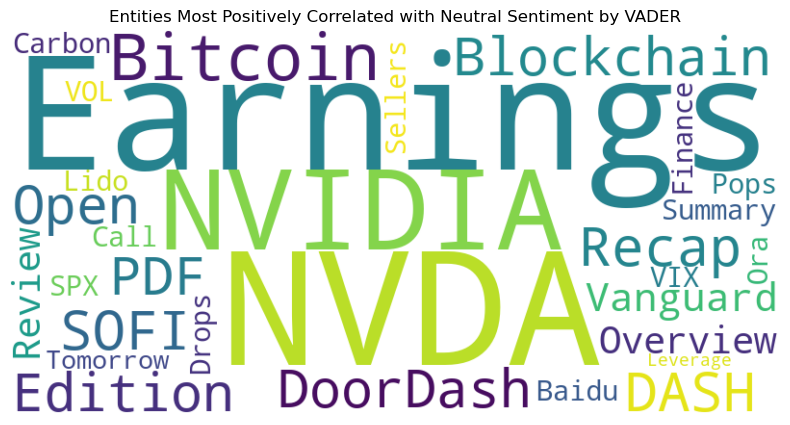

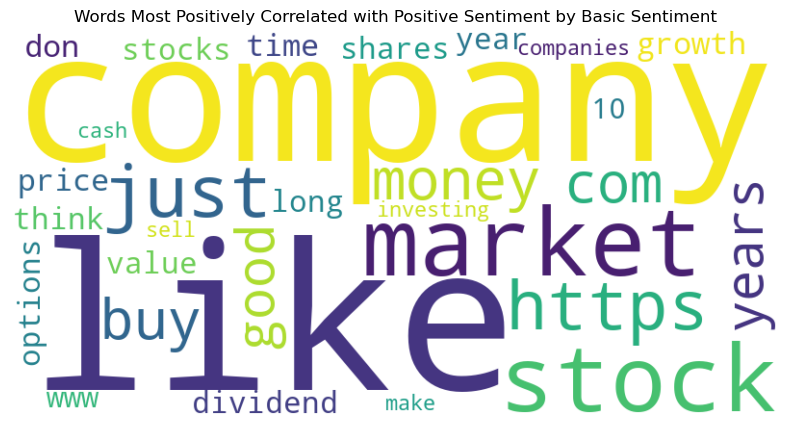

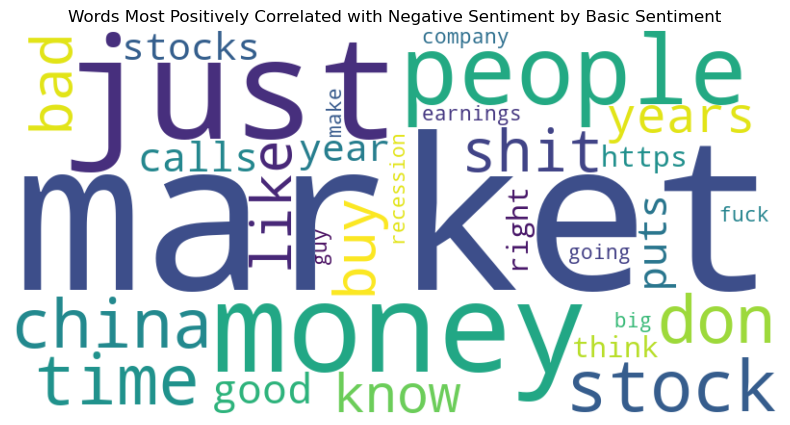

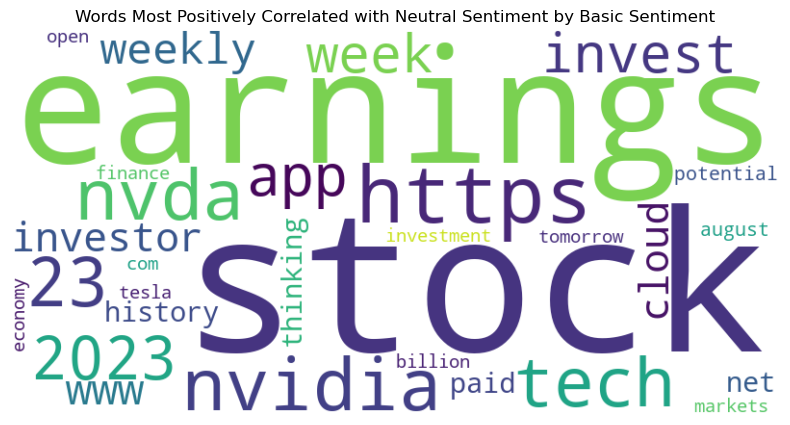

In [295]:
from wordcloud import WordCloud

# this is a function to generate word cloud
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# counting the entities based on sentiment for VADER
for sentiment in ['Positive', 'Negative', 'Neutral']:
    common_entities = Counter([entity for index, row in df[df['Sentiment'] == sentiment].iterrows() for entity in row['Entities']]).most_common(30)
    print(f"Entities Most Positively Correlated with {sentiment} Sentiment by VADER:")
    print(common_entities)
    
    # creating a dictionary with entities and their counts for word cloud
    entities_dict = dict(common_entities)
    
    # generating word cloud
    generate_wordcloud(entities_dict, f"Entities Most Positively Correlated with {sentiment} Sentiment by VADER")

# performing a TF-IDF Vectorization for Basic Sentiment
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_result = tfidf.fit_transform(df['Complete_Text']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf.get_feature_names_out())
tfidf_df['Sentiment'] = df['Sentiment']

# counting words based on sentiment for Basic Sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    temp_df = tfidf_df[tfidf_df['Sentiment'] == sentiment]
    mean_scores = temp_df.drop('Sentiment', axis=1).mean()
    
    most_common_words = mean_scores.sort_values(ascending=False).head(30).to_dict()
    
    generate_wordcloud(most_common_words, f"Words Most Positively Correlated with {sentiment} Sentiment by Basic Sentiment")


In [296]:
#Context-based Sentiment Analysis

us_positive_contexts = df[(df['Sentiment'] == 'Positive') & df['Entities'].apply(lambda x: 'US' in x)]['Complete_Text']
us_negative_contexts = df[(df['Sentiment'] == 'Negative') & df['Entities'].apply(lambda x: 'US' in x)]['Complete_Text']

print("Positive contexts where 'US' appears:\n", us_positive_contexts.sample(5).values)
print("Negative contexts where 'US' appears:\n", us_negative_contexts.sample(5).values)


Positive contexts where 'US' appears:
 ["One of Seth Klarman’s biggest positions as of 6/30/23 was NYSE:FIS TEV: $50.6 billion\nTTM EBITDA: $4.1 billion (11.7x)\n2023E EBITDA: $6.1 billion (8.3x)\nDividend yield: 3.7%\nLimited capex (~$250mm annually), so high FCF to EBITDA conversion\n\nThey recently announced a spin-off of Worldpay to GTCR (but retained 45% ownership).\n\nThe balance sheet doesn’t provide much of a margin of safety because tangible book value is negative.\n\nWhat do you guys think? ['Well the tangible book value thing is not the best indicator. Given the sale of WorldPay to GTCR, it should be valued as an 18.5 billion hard asset. Apparently there were multiple bids for it so I think it has pretty good liquidity. \\n\\nI think the rest of the business, banking and capital markets, does like 10 billion in revenue with 20% FCF margins. So the remaining business will probably generated 2 billion in FCF this year.\\n\\nWorldPay has some serious challenges, with Adyen, Pay

In [329]:
#Context-based Sentiment Analysis

us_positive_contexts = df[(df['Sentiment'] == 'Positive') & df['Entities'].apply(lambda x: 'US' in x)]['Complete_Text']
us_negative_contexts = df[(df['Sentiment'] == 'Negative') & df['Entities'].apply(lambda x: 'US' in x)]['Complete_Text']

print("Positive contexts where 'US' appears:\n", us_positive_contexts.sample(1).values)
print("Negative contexts where 'US' appears:\n", us_negative_contexts.sample(1).values)


Positive contexts where 'US' appears:
 ['Any idea why Morningstar has VTI as a 3 star fund and VOO as 5 star? I was looking at transitioning some of my positions from a few different areas over to VOO or VTI and in researching on Morningstar they have VTI only rated 3 stars and VOO as 5 stars. From what I\'ve read and seen, they are essentially the same, so what\'s their reasoning for the big gap in confidence? ["As someone who once based a lot of their investment decisions on Morningstar (in the early 90\'s) I can tell you with a great deal of certainty that their rating system has almost no correlation with real world results. They\'re about as useful as a wooden parachute.", \'It’s likely due to VOO being all large cap while VTI has exposure to mid and small cap companies. This just means to me Morningstar analysts look more favorably on large cap stock potential than a blend of L/M/S. As others have said, their ratings are kind of poo-poo.\', \'Because Morningstar’s rating methodol

In [333]:
#Context-based Sentiment Analysis

us_positive_contexts = df[(df['Sentiment'] == 'Positive') & df['Entities'].apply(lambda x: 'China' in x)]['Complete_Text']
us_negative_contexts = df[(df['Sentiment'] == 'Negative') & df['Entities'].apply(lambda x: 'China' in x)]['Complete_Text']

print("Positive contexts where 'China' appears:\n", us_positive_contexts.sample(1).values)
print("Negative contexts where 'China' appears:\n", us_negative_contexts.sample(1).values)


Positive contexts where 'China' appears:
 ['Announcements x Daily Discussion for Weekend of August 18, 2023 Welcome to the Weekend Discussion! Please use this thread for questions & chitchat, and leave the main sub for breaking news or DD.\n\nIf you haven\'t already, please check out the [/r/SPACs Wiki](https://www.reddit.com/r/SPACs/wiki/index) for answers to frequently asked questions.\n\nHappy SPACing! [\'In other shocking news DMS reverse splitting….yeah guys, we really believe now that you had a legit offer for $2.50….\\n\\nThese people are so bad and downright disgusting.\', "https://en.as.com/latest_news/evergrande-bankruptcy-how-could-chinas-real-estate-giant-crisis-impact-the-global-economy-n/\\n\\nGeneral stock market discussion: everyone\'s been drilled that there is an impending US recession, blah blah blah. But I hadn\'t paid much attention until recently to the state of China\'s economy. If there\'s a black swan 2008ish type event over there, what would we expect to happe

In [299]:
#Co-occurence Analysis
from itertools import combinations

# Function to get combinations of entities in each comment
def get_combinations(entity_list):
    return list(combinations(entity_list, 2))

# Co-occurrence in Negative Sentiment
negative_combinations = df[df['Sentiment'] == 'Negative']['Entities'].apply(get_combinations)
negative_flat_combinations = [item for sublist in negative_combinations for item in sublist]
negative_common_combinations = Counter(negative_flat_combinations).most_common(100)
print("Most Common Co-occurrences in Negative Sentiment:", negative_common_combinations)


Most Common Co-occurrences in Negative Sentiment: [(('Roth', 'Roth'), 213), (('China', 'China'), 156), (('Roth', 'IRA'), 94), (('IRA', 'Roth'), 60), (('China', 'CCP'), 56), (('Traditional', 'Roth'), 55), (('S', 'P'), 47), (('USA', 'US'), 46), (('Chengdu', 'China'), 37), (('CCP', 'China'), 34), (('COVID', 'China'), 32), (('Cleveland', 'Cleveland'), 31), (('IV', 'IV'), 31), (('IRAs', 'Roth'), 28), (('S', 'S'), 26), (('US', 'US'), 25), (('China', 'Estate'), 23), (('IV', 'PYPL'), 23), (('Evergrande', 'China'), 22), (('IRA', 'IRA'), 22), (('US', 'China'), 21), (('Traditional', 'IRA'), 21), (('ARK', 'ARK'), 21), (('Beijing', 'China'), 21), (('Salesforce', 'Salesforce'), 21), (('S', 'Federal'), 21), (('Burry', 'Burry'), 21), (('Amazon', 'IV'), 21), (('IV', 'Inc'), 21), (('Market', 'Roth'), 20), (('VOO', 'US'), 20), (('P', 'S'), 20), (('P', 'P'), 20), (('Burry', 'Babson'), 20), (('Anixa', 'T'), 19), (('T', 'T'), 19), (('Roth', 'No'), 19), (('Which', 'Roth'), 19), (('Shit', 'China'), 19), (('Cl

In [300]:
from itertools import combinations
from collections import Counter
import pandas as pd


# Function to get combinations of entities in each comment and removing 'AND' from the analysis
def get_combinations(entity_list):
    return [comb for comb in combinations(entity_list, 2) if 'AND' not in comb]

# Co-occurrences in Positive Sentiment
positive_combinations = df[df['Sentiment'] == 'Positive']['Entities'].apply(get_combinations)
positive_flat_combinations = [item for sublist in positive_combinations for item in sublist]

positive_common_combinations = Counter(positive_flat_combinations).most_common(100)

print("Most Common Co-occurrences in Positive Sentiment:", positive_common_combinations)


Most Common Co-occurrences in Positive Sentiment: [(('June', 'Amazon'), 1760), (('Amazon', 'Amazon'), 1739), (('Netflix', 'Netflix'), 1378), (('June', 'June'), 1360), (('JEPI', 'JEPI'), 1018), (('SPX', 'SPX'), 874), (('Disney', 'Disney'), 861), (('IV', 'IV'), 775), (('Amazon', 'June'), 756), (('EBITDA', 'EBITDA'), 741), (('SERVICES', 'GROUP'), 614), (('IRA', 'IRA'), 613), (('ES', 'SPX'), 565), (('SPX', 'ES'), 549), (('GROUP', 'GROUP'), 496), (('June', 'AWS'), 486), (('Berkshire', 'Berkshire'), 468), (('ATKR', 'ATKR'), 435), (('GAS', 'GROUP'), 433), (('SERVICES', 'BROKERAGE'), 418), (('ES', 'ES'), 409), (('Roth', 'Roth'), 397), (('SERVICES', 'GAS'), 394), (('Blockbuster', 'Netflix'), 384), (('GROUP', 'BROKERAGE'), 376), (('INDUSTRIAL', 'GROUP'), 371), (('Roth', 'IRA'), 352), (('SERVICES', 'SERVICES'), 351), (('Apple', 'Apple'), 347), (('SERVICES', 'INVESTMENT'), 345), (('IRA', 'Roth'), 343), (('US', 'US'), 339), (('Amazon', 'AWS'), 337), (('O', 'O'), 330), (('AI', 'AI'), 329), (('SMCI',

In [319]:
from itertools import combinations
from collections import Counter
import pandas as pd

def get_combinations(entity_list):
    return [comb for comb in combinations(entity_list, 2) if comb[0] != comb[1]]

negative_combinations = df[df['Sentiment'] == 'Negative']['Entities'].apply(get_combinations)
negative_flat_combinations = [item for sublist in negative_combinations for item in sublist]
negative_common_combinations = Counter(negative_flat_combinations).most_common(100)

# Filtering out the co-occurrences with repeated entities
negative_common_combinations = [(entities, count) for entities, count in negative_common_combinations if entities[0] != entities[1]]

print("Most Common Co-occurrences in Negative Sentiment:", negative_common_combinations)


Most Common Co-occurrences in Negative Sentiment: [(('Roth', 'IRA'), 94), (('IRA', 'Roth'), 60), (('China', 'CCP'), 56), (('Traditional', 'Roth'), 55), (('S', 'P'), 47), (('USA', 'US'), 46), (('Chengdu', 'China'), 37), (('CCP', 'China'), 34), (('COVID', 'China'), 32), (('IRAs', 'Roth'), 28), (('China', 'Estate'), 23), (('IV', 'PYPL'), 23), (('Evergrande', 'China'), 22), (('US', 'China'), 21), (('Traditional', 'IRA'), 21), (('Beijing', 'China'), 21), (('S', 'Federal'), 21), (('Amazon', 'IV'), 21), (('IV', 'Inc'), 21), (('Market', 'Roth'), 20), (('VOO', 'US'), 20), (('P', 'S'), 20), (('Burry', 'Babson'), 20), (('Anixa', 'T'), 19), (('Roth', 'No'), 19), (('Which', 'Roth'), 19), (('Shit', 'China'), 19), (('Cleveland', 'Canada'), 19), (('China', 'US'), 18), (('Erie', 'Cleveland'), 18), (('P', 'Federal'), 18), (('HE', 'PCG'), 17), (('Roth', 'IRAs'), 17), (('Discover', 'DFS'), 17), (('China', 'Evergrande'), 16), (('China', 'COVID'), 16), (('Economy', 'China'), 16), (('Roth', 'RMD'), 16), (('L

In [320]:
from itertools import combinations
from collections import Counter
import pandas as pd

def get_combinations(entity_list):
    return [comb for comb in combinations(entity_list, 2) if 'AND' not in comb and comb[0] != comb[1]]

positive_combinations = df[df['Sentiment'] == 'Positive']['Entities'].apply(get_combinations)
positive_flat_combinations = [item for sublist in positive_combinations for item in sublist]
positive_common_combinations = Counter(positive_flat_combinations).most_common(100)

# Filtering out the co-occurrences with repeated entities
positive_common_combinations = [(entities, count) for entities, count in positive_common_combinations if entities[0] != entities[1]]

print("Most Common Co-occurrences in Positive Sentiment:", positive_common_combinations)


Most Common Co-occurrences in Positive Sentiment: [(('June', 'Amazon'), 1760), (('Amazon', 'June'), 756), (('SERVICES', 'GROUP'), 614), (('ES', 'SPX'), 565), (('SPX', 'ES'), 549), (('June', 'AWS'), 486), (('GAS', 'GROUP'), 433), (('SERVICES', 'BROKERAGE'), 418), (('SERVICES', 'GAS'), 394), (('Blockbuster', 'Netflix'), 384), (('GROUP', 'BROKERAGE'), 376), (('INDUSTRIAL', 'GROUP'), 371), (('Roth', 'IRA'), 352), (('SERVICES', 'INVESTMENT'), 345), (('IRA', 'Roth'), 343), (('Amazon', 'AWS'), 337), (('SERVICES', 'INDUSTRIAL'), 313), (('ELNs', 'JEPI'), 312), (('Apple', 'Amazon'), 309), (('GROUP', 'GAS'), 303), (('GAS', 'BROKERAGE'), 297), (('GROUP', 'INVESTMENT'), 297), (('OIL', 'GROUP'), 294), (('Netflix', 'Cash'), 287), (('Netflix', 'Flow'), 287), (('COAL', 'GROUP'), 282), (('INVESTMENT', 'GROUP'), 279), (('SERVICES', 'SUPPORT'), 278), (('CREDIT', 'GROUP'), 268), (('BROKERAGE', 'GROUP'), 264), (('INDUSTRIAL', 'BROKERAGE'), 258), (('GROUP', 'SERVICES'), 250), (('PowerShell', 'CIK'), 238), ((

Sentiment distribution for EBITDA: Positive    19
Negative     2
Name: Sentiment, dtype: int64


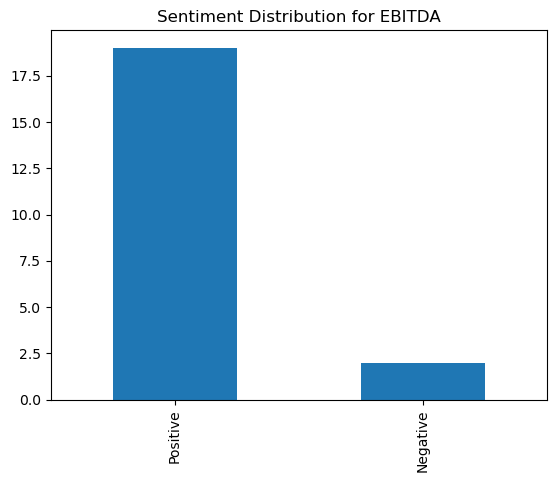

Sentiment distribution for PE: Positive    38
Negative     5
Name: Sentiment, dtype: int64


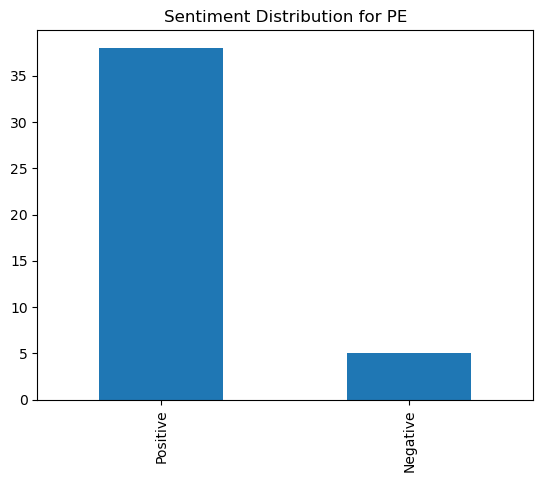

In [301]:
import matplotlib.pyplot as plt

# Filtering comments containing 'EBITDA'
ebitda_comments = df[df['Entities'].apply(lambda x: 'EBITDA' in x)]

# Displaying sentiment distribution for EBITDA
ebitda_sentiment_count = ebitda_comments['Sentiment'].value_counts()
print("Sentiment distribution for EBITDA:", ebitda_sentiment_count)
ebitda_sentiment_count.plot(kind='bar', title='Sentiment Distribution for EBITDA')
plt.show()

# Filtering comments containing 'PE'
pe_comments = df[df['Entities'].apply(lambda x: 'PE' in x)]

# Displaying sentiment distribution for PE
pe_sentiment_count = pe_comments['Sentiment'].value_counts()
print("Sentiment distribution for PE:", pe_sentiment_count)
pe_sentiment_count.plot(kind='bar', title='Sentiment Distribution for PE')
plt.show()


Sentiment distribution for VOO: Positive    70
Negative     5
Name: Sentiment, dtype: int64


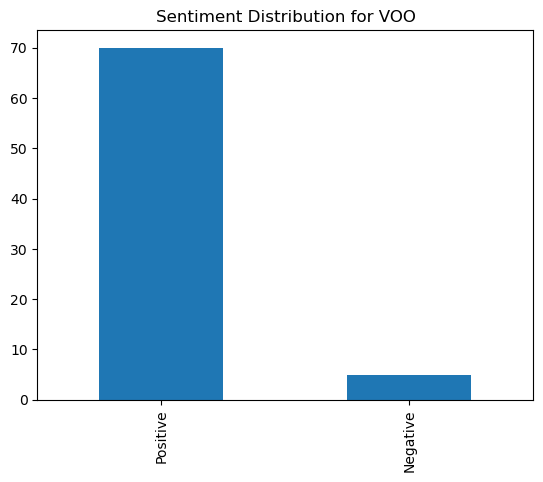

Sentiment distribution for SPY: Positive    68
Negative    10
Name: Sentiment, dtype: int64


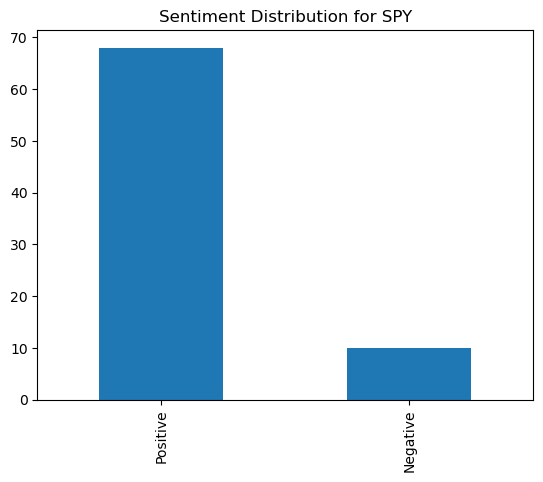

In [302]:
# Filtering comments containing 'VOO'
voo_comments = df[df['Entities'].apply(lambda x: 'VOO' in x)]

# Displaying sentiment distribution for VOO
voo_sentiment_count = voo_comments['Sentiment'].value_counts()
print("Sentiment distribution for VOO:", voo_sentiment_count)
voo_sentiment_count.plot(kind='bar', title='Sentiment Distribution for VOO')
plt.show()

# Filtering comments containing 'SPY'
spy_comments = df[df['Entities'].apply(lambda x: 'SPY' in x)]

# Displaying sentiment distribution for SPY
spy_sentiment_count = spy_comments['Sentiment'].value_counts()
print("Sentiment distribution for SPY:", spy_sentiment_count)
spy_sentiment_count.plot(kind='bar', title='Sentiment Distribution for SPY')
plt.show()


In [303]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from textblob import TextBlob

In [304]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def tokenize_and_filter(text):
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(filtered_tokens)

df['FilteredComments'] = df['Comments'].apply(tokenize_and_filter)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amayiyer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [305]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)
#i am using the tfidf vectorizer again for my analysis

In [306]:
def perform_lda(df_filtered_comments):
    tfidf = tfidf_vectorizer.fit_transform(df_filtered_comments)
    lda_model = LDA(n_components=5)
    lda_model.fit(tfidf)
    
    for i, topic in enumerate(lda_model.components_):
        print(f'Top 10 words for topic #{i}:')
        print([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
        print('\n')
#Latent Dirichlet Allocation is another sentiment analysis method that tries to cluster a bunch 
#of words appearing together in association to constitute a topic

In [307]:
pe_comments = df[df['Entities'].apply(lambda x: 'PE' in x)]['FilteredComments']
ebitda_comments = df[df['Entities'].apply(lambda x: 'EBITDA' in x)]['FilteredComments']

print("Topic Modeling for PE:")
perform_lda(pe_comments)

print("Topic Modeling for EBITDA:")
perform_lda(ebitda_comments)


Topic Modeling for PE:
Top 10 words for topic #0:
['company', 'see', 'cheap', 'market', 'price', 'like', 'years', 'gold', 'solar', 'growth']


Top 10 words for topic #1:
['valuation', 'market', 'nvidia', 'buy', 'growth', 'graham', 'oil', 'time', 'value', 'investing']


Top 10 words for topic #2:
['warren', 'market', 'data', 'tool', 'company', 'nvidia', 'stock', 'coal', 'revenue', 'usd']


Top 10 words for topic #3:
['would', 'good', 'believe', 'ceo', 'buybacks', 'coal', 'price', 'secondary', 'insider', 'company']


Top 10 words for topic #4:
['roe', 'good', 'debt', 'companies', 'capital', 'company', 'amd', 'nvidia', 'ebitda', 'group']


Topic Modeling for EBITDA:
Top 10 words for topic #0:
['added', 'dd', 'fan', 'deep', 'events', 'history', 'pattern', 'calculation', 'intrinsic', 'highlight']


Top 10 words for topic #1:
['let', 'fan', 'dd', 'deep', 'events', 'history', 'pattern', 'calculation', 'highlight', 'intrinsic']


Top 10 words for topic #2:
['fan', 'history', 'events', 'pattern

In [308]:
voo_comments = df[df['Entities'].apply(lambda x: 'VOO' in x)]['FilteredComments']
spy_comments = df[df['Entities'].apply(lambda x: 'SPY' in x)]['FilteredComments']

print("Topic Modeling for VOO:")
perform_lda(voo_comments)

print("Topic Modeling for SPY:")
perform_lda(spy_comments)


Topic Modeling for VOO:
Top 10 words for topic #0:
['fractional', 'inception', 'eyes', 'passed', 'benefits', 'impressed', 'oriented', 'div', 'schb', 'vym']


Top 10 words for topic #1:
['allowed', 'inception', 'eyes', 'passed', 'benefits', 'impressed', 'oriented', 'div', 'schb', 'vym']


Top 10 words for topic #2:
['portfolio', 'stock', 'years', 'would', 'dividend', 'like', 'growth', 'stocks', 'money', 'market']


Top 10 words for topic #3:
['eyes', 'finally', 'event', 'benefits', 'allowed', 'owning', 'oriented', 'vym', 'schb', 'div']


Top 10 words for topic #4:
['fractional', 'tomorrow', 'eyes', 'benefits', 'passed', 'oriented', 'div', 'impressed', 'schb', 'vym']


Topic Modeling for SPY:
Top 10 words for topic #0:
['would', 'investing', 'company', 'time', 'stocks', 'index', 'years', 'short', 'money', 'like']


Top 10 words for topic #1:
['time', 'day', 'put', 'spy', 'people', 'buy', 'like', 'price', 'puts', 'trade']


Top 10 words for topic #2:
['income', 'nasdaq', 'spy', 'growth', 

Topic Modeling for PE:


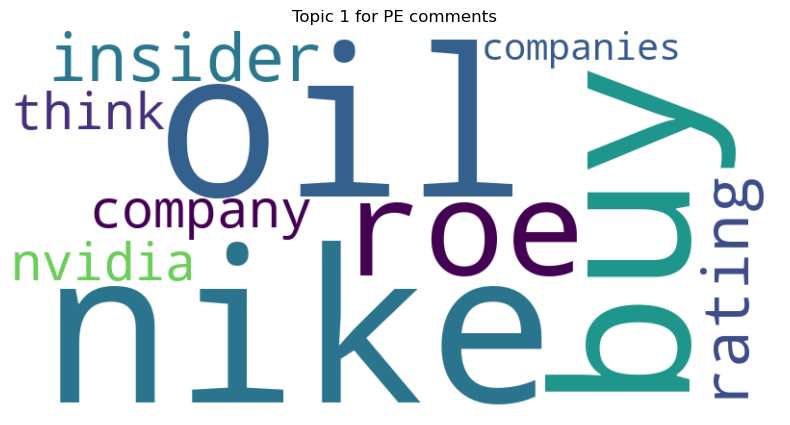

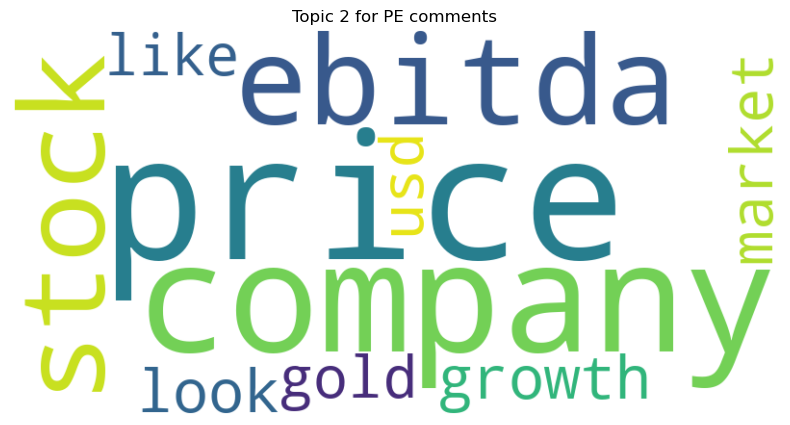

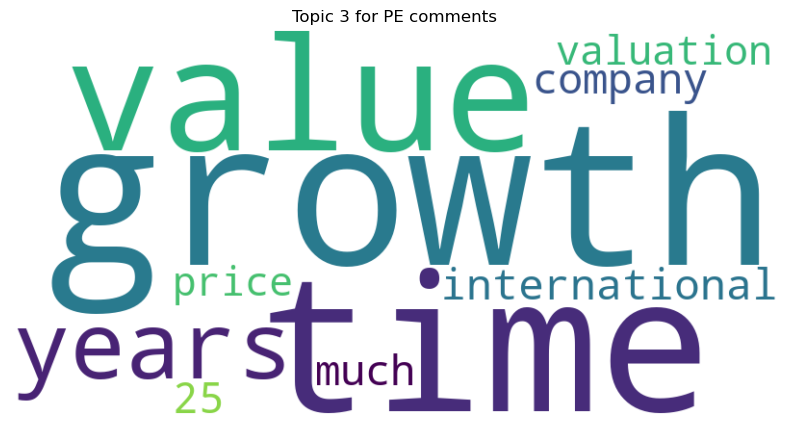

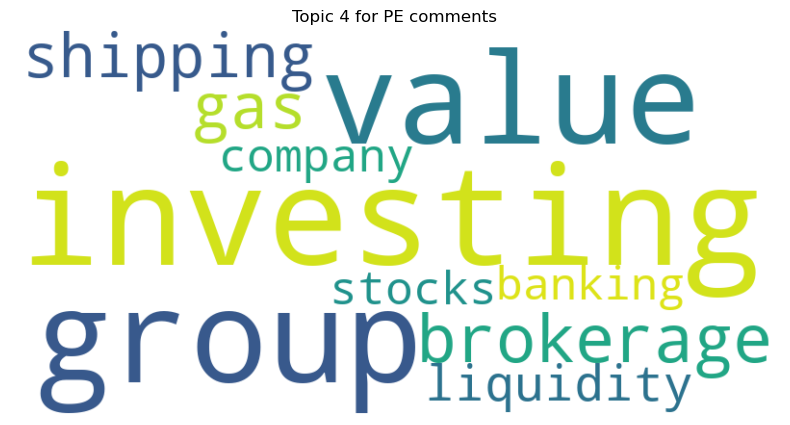

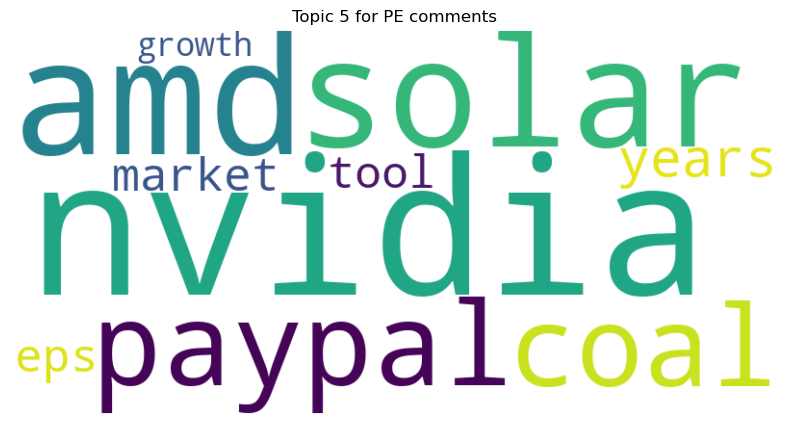

Topic Modeling for EBITDA:


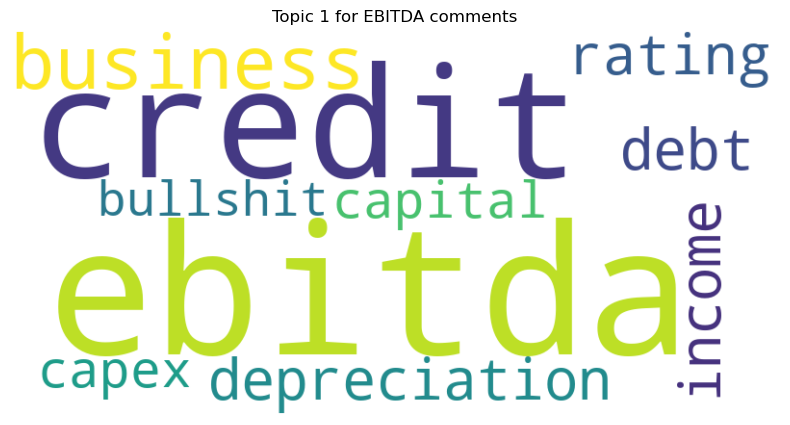

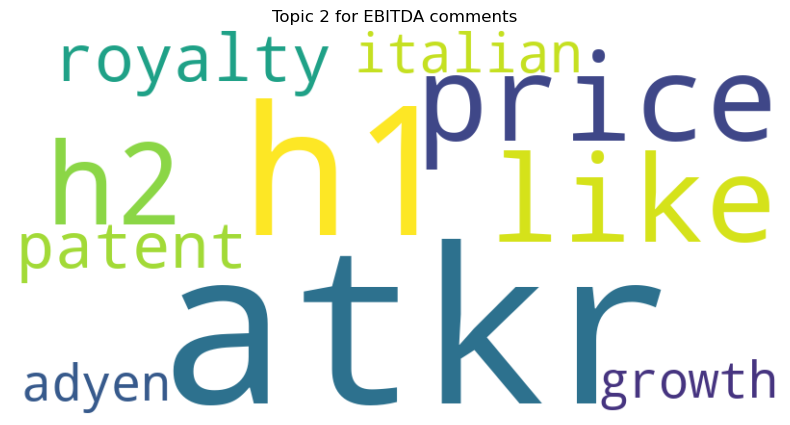

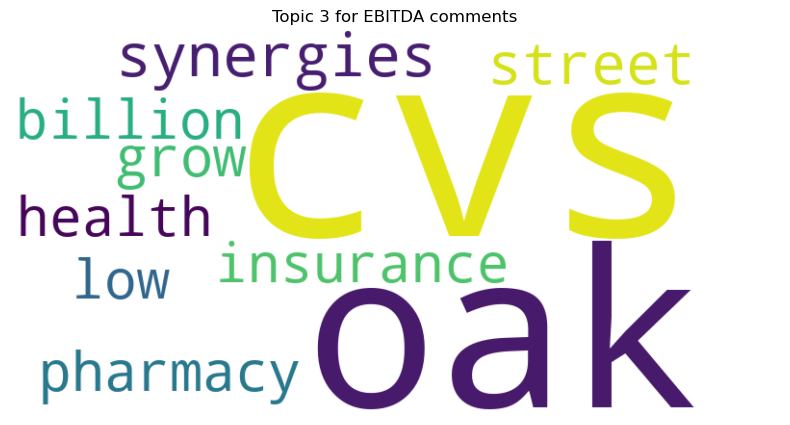

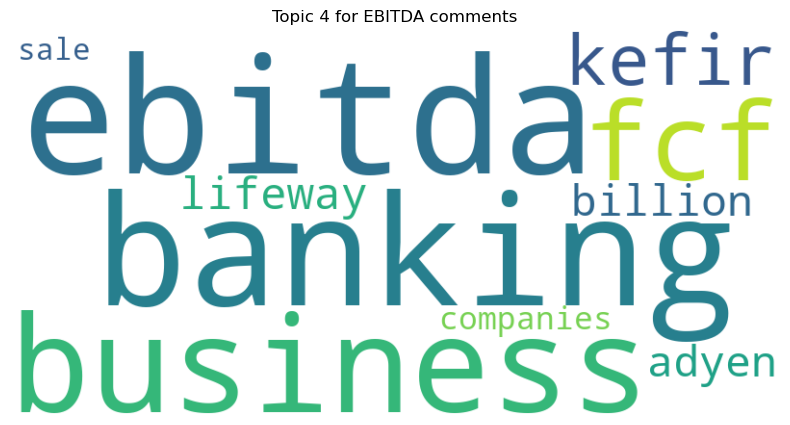

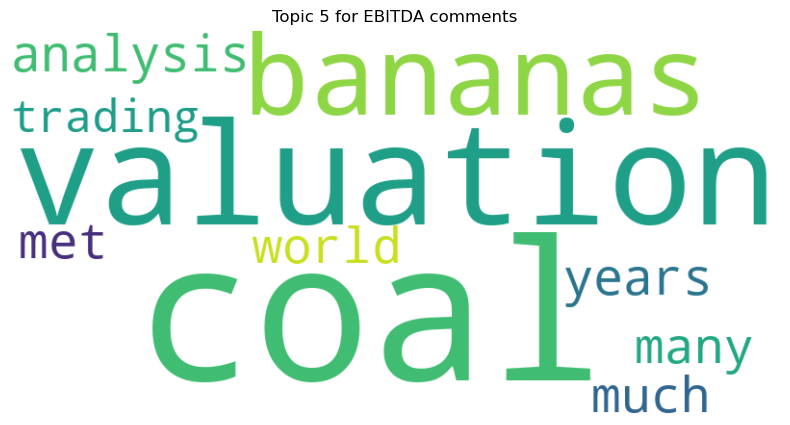

Topic Modeling for VOO:


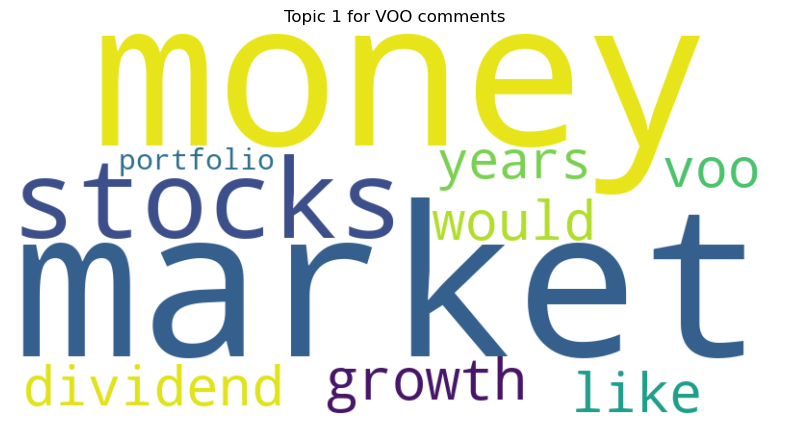

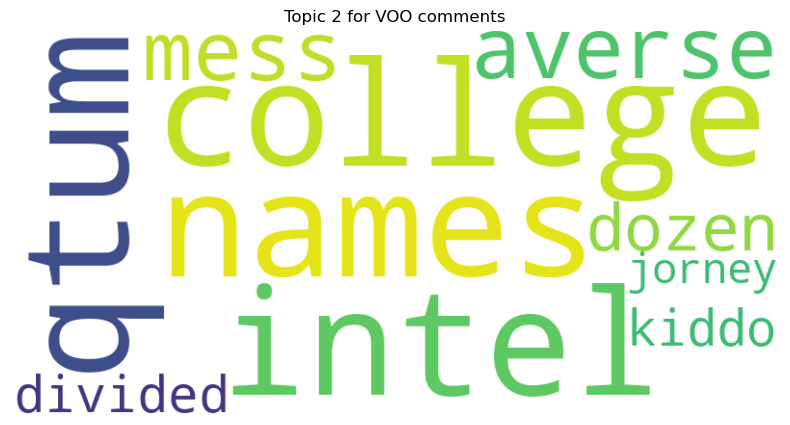

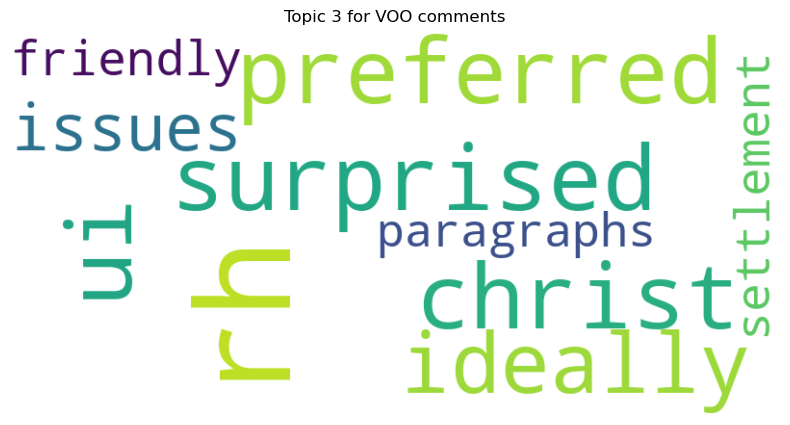

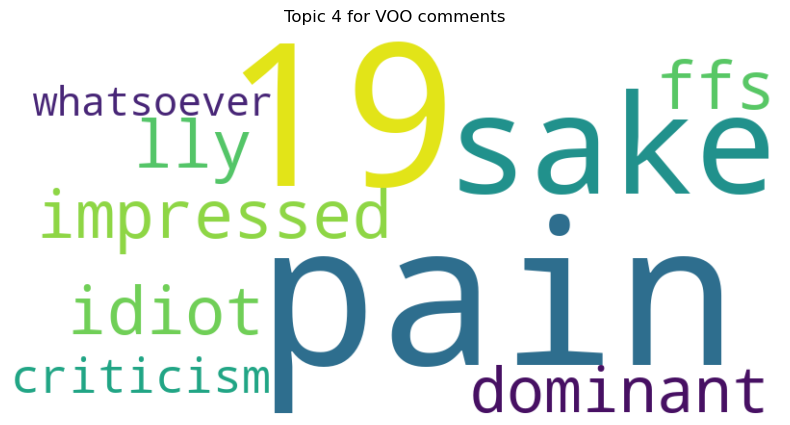

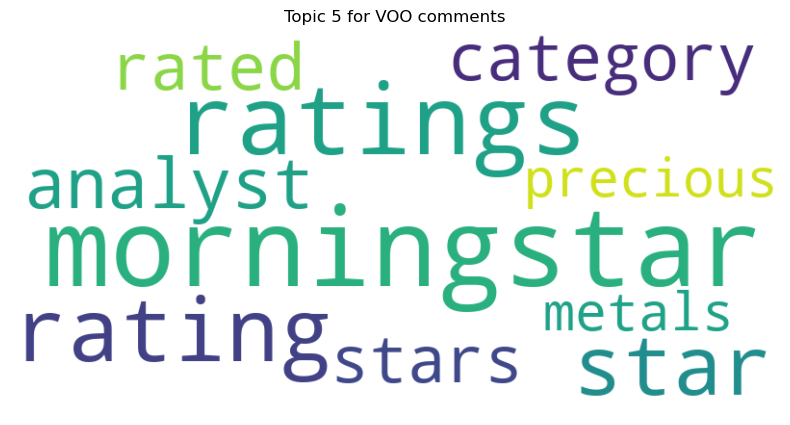

Topic Modeling for SPY:


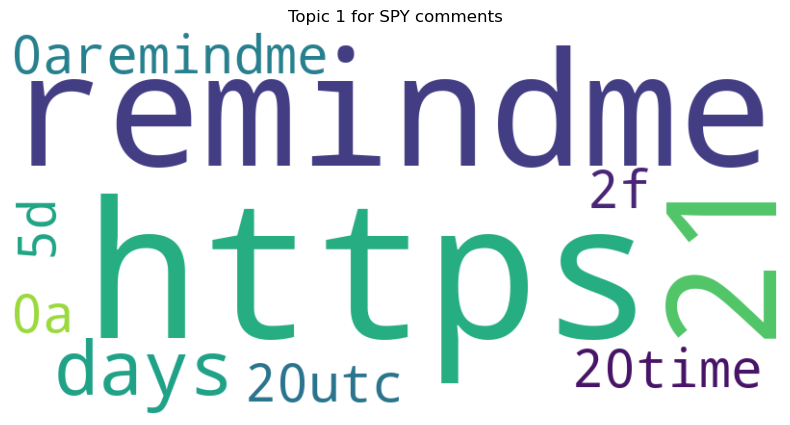

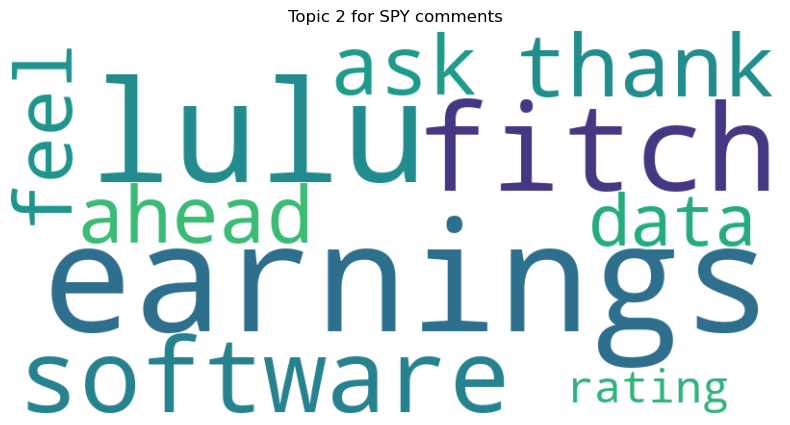

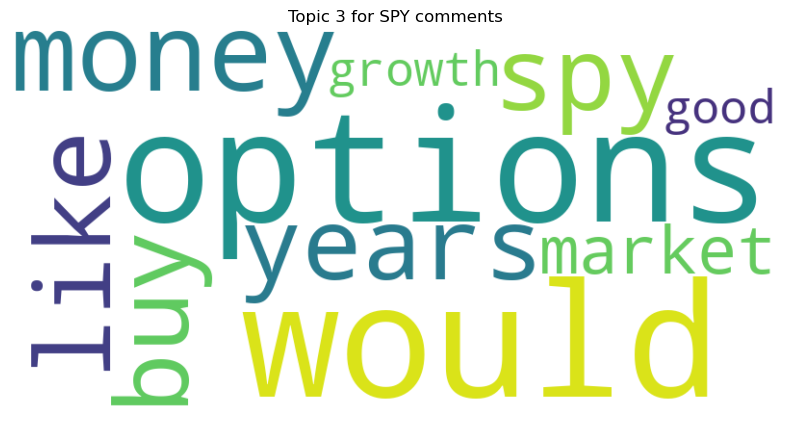

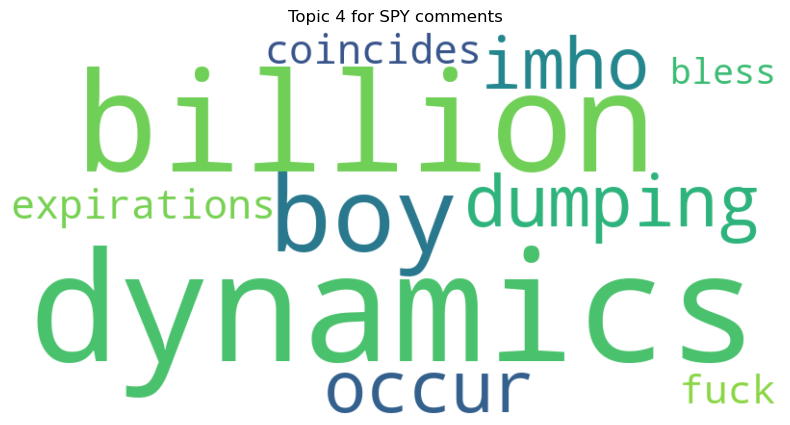

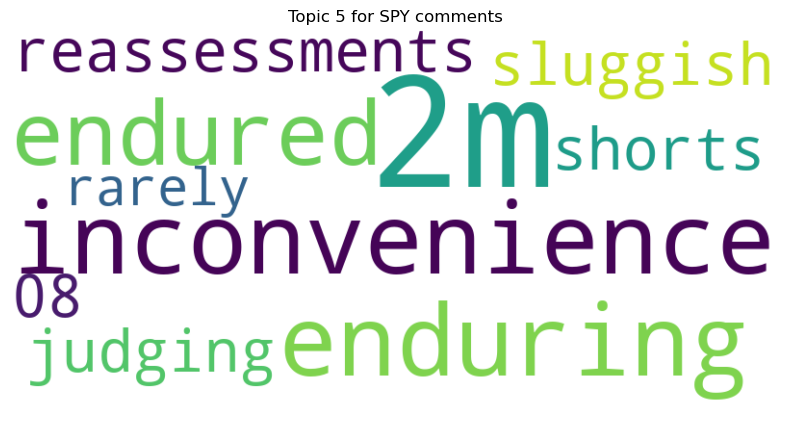

In [309]:
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer

# Initializing TFIDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Function to perform LDA and return components and feature names
def perform_lda(df_filtered_comments):
    tfidf = tfidf_vectorizer.fit_transform(df_filtered_comments)
    lda_model = LDA(n_components=5)
    lda_model.fit(tfidf)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    return lda_model.components_, feature_names

# Function to generate word cloud
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Function for generating a word clouds from LDA model
def lda_to_wordcloud(lda_components, feature_names, comment_type):
    for i, topic in enumerate(lda_components):
        words_freq = [(feature_names[j], topic[j]) for j in topic.argsort()[-10:]]
        generate_wordcloud(dict(words_freq), f"Topic {i + 1} for {comment_type} comments")

# Generating LDA models and word clouds
comments_types = ['PE', 'EBITDA', 'VOO', 'SPY']
for comment_type in comments_types:
    comments = df[df['Entities'].apply(lambda x: comment_type in x)]['FilteredComments']
    print(f"Topic Modeling for {comment_type}:")
    lda_components, feature_names = perform_lda(comments)
    lda_to_wordcloud(lda_components, feature_names, comment_type)


In [310]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'
    
df['DetailedSentiment'] = df['Comments'].apply(get_sentiment)
#i am getting the detailed sentiment above so I can get an in-depth understanding of the LDA model

/var/folders/8y/9bzf6lrd1kggm5429dypyz2r0000gn/T/ipykernel_6181/1187288350.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pe_comments['Dominant_Topic'] = pe_comments['FilteredComments'].apply(get_dominant_topic, args=(lda_model, tfidf_vectorizer))
/var/folders/8y/9bzf6lrd1kggm5429dypyz2r0000gn/T/ipykernel_6181/1187288350.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebitda_comments['Dominant_Topic'] = ebitda_comments['FilteredComments'].apply(get_dominant_topic, args=(lda_model, tfidf_vectorize

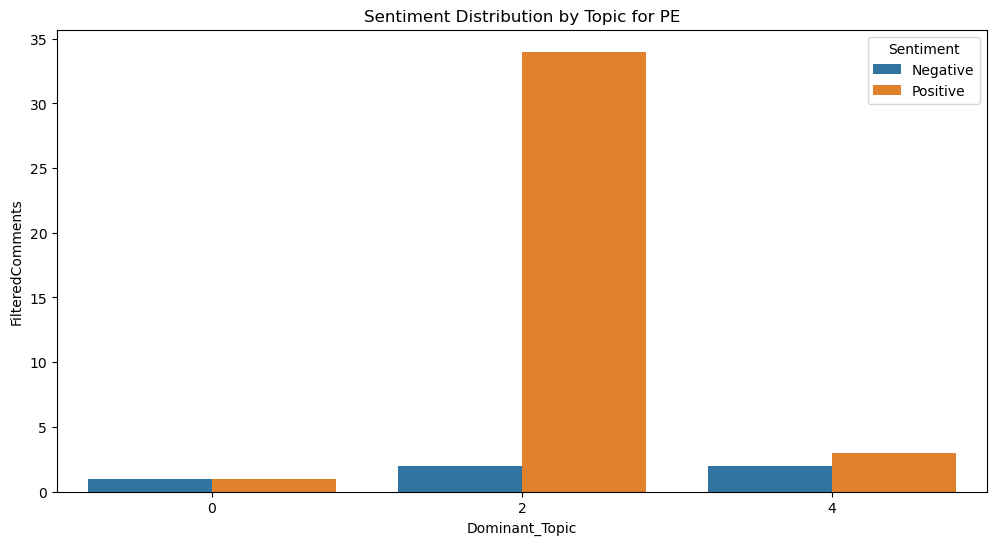

In [311]:
#the following analysis was done after writing the report hence is not mentioned in the report

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to get the dominant topic for each comment
def get_dominant_topic(comment, model, vectorizer):
    vec_comment = vectorizer.transform([comment])
    topic_probability_scores = model.transform(vec_comment)
    dominant_topic = topic_probability_scores.argmax()
    return dominant_topic

# Sampling the DataFrames (assume df is your original DataFrame)
pe_comments = df[df['Entities'].apply(lambda x: 'PE' in x)]['FilteredComments']
ebitda_comments = df[df['Entities'].apply(lambda x: 'EBITDA' in x)]['FilteredComments']

# Creating and fit the TF-IDF vectorizer and LDA model
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
pe_tfidf = tfidf_vectorizer.fit_transform(pe_comments)
ebitda_tfidf = tfidf_vectorizer.fit_transform(ebitda_comments)

lda_model = LDA(n_components=5, random_state=42)
lda_model.fit(pe_tfidf)
lda_model.fit(ebitda_tfidf)

# Getting Dominant Topic for each comment
pe_comments = df[df['Entities'].apply(lambda x: 'PE' in x)]
ebitda_comments = df[df['Entities'].apply(lambda x: 'EBITDA' in x)]

pe_comments['Dominant_Topic'] = pe_comments['FilteredComments'].apply(get_dominant_topic, args=(lda_model, tfidf_vectorizer))
ebitda_comments['Dominant_Topic'] = ebitda_comments['FilteredComments'].apply(get_dominant_topic, args=(lda_model, tfidf_vectorizer))

# Assuming my DataFrame has a 'Sentiment' column to group by
pe_grouped = pe_comments.groupby(['Dominant_Topic', 'Sentiment']).count().reset_index()
ebitda_grouped = ebitda_comments.groupby(['Dominant_Topic', 'Sentiment']).count().reset_index()

# Visualization for PE
plt.figure(figsize=(12, 6))
sns.barplot(x='Dominant_Topic', y='FilteredComments', hue='Sentiment', data=pe_grouped)
plt.title('Sentiment Distribution by Topic for PE')
plt.show()


/var/folders/8y/9bzf6lrd1kggm5429dypyz2r0000gn/T/ipykernel_6181/2270392197.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebitda_comments['Dominant_Topic'] = ebitda_comments['FilteredComments'].apply(get_dominant_topic, args=(lda_model_ebitda, tfidf_vectorizer_ebitda))
/var/folders/8y/9bzf6lrd1kggm5429dypyz2r0000gn/T/ipykernel_6181/2270392197.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voo_comments['Dominant_Topic'] = voo_comments['FilteredComments'].apply(get_dominant_topic, args=(lda_model_

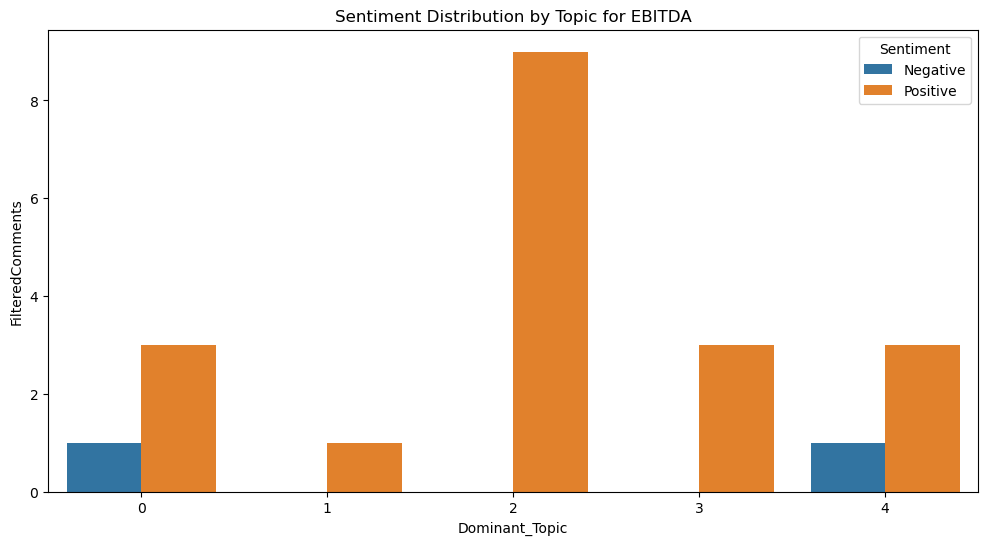

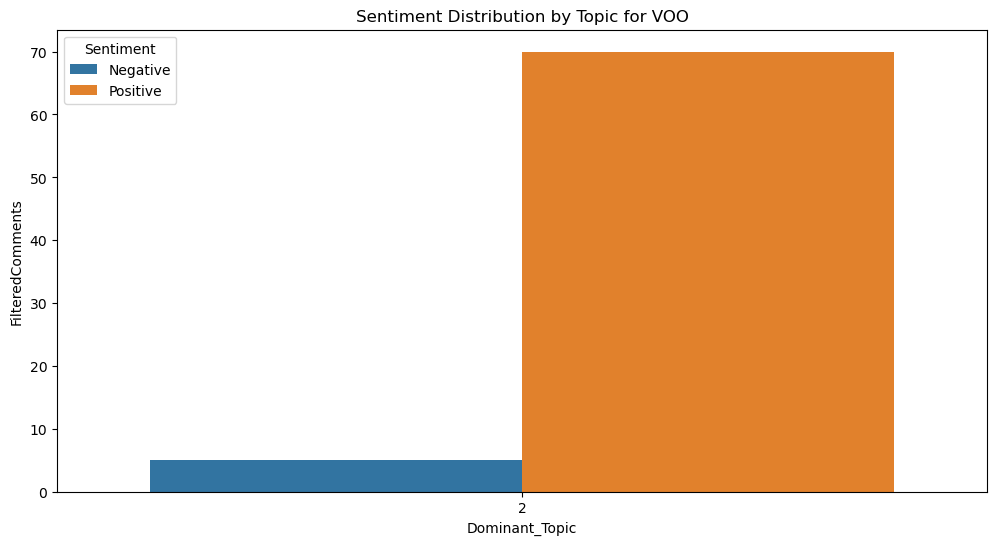

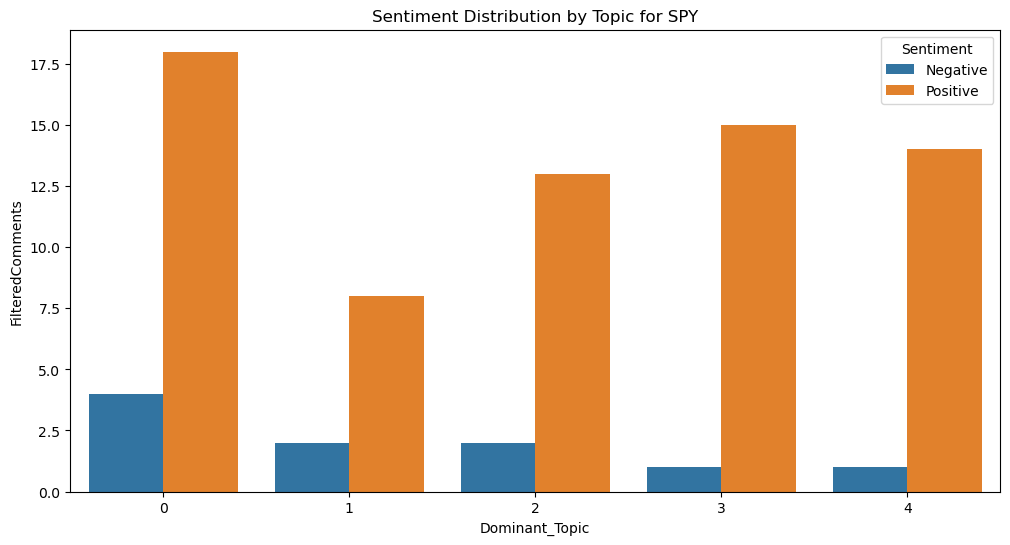

In [312]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_dominant_topic(comment, model, vectorizer):
    vec_comment = vectorizer.transform([comment])
    topic_probability_scores = model.transform(vec_comment)
    dominant_topic = topic_probability_scores.argmax()
    return dominant_topic

ebitda_comments = df[df['Entities'].apply(lambda x: 'EBITDA' in x)]['FilteredComments']
voo_comments = df[df['Entities'].apply(lambda x: 'VOO' in x)]['FilteredComments']
spy_comments = df[df['Entities'].apply(lambda x: 'SPY' in x)]['FilteredComments']

# Creating and fit the TF-IDF vectorizer and LDA model for EBITDA
tfidf_vectorizer_ebitda = TfidfVectorizer(stop_words='english')
ebitda_tfidf = tfidf_vectorizer_ebitda.fit_transform(ebitda_comments)
lda_model_ebitda = LDA(n_components=5, random_state=42)
lda_model_ebitda.fit(ebitda_tfidf)

# Creating and fit the TF-IDF vectorizer and LDA model for VOO
tfidf_vectorizer_voo = TfidfVectorizer(stop_words='english')
voo_tfidf = tfidf_vectorizer_voo.fit_transform(voo_comments)
lda_model_voo = LDA(n_components=5, random_state=42)
lda_model_voo.fit(voo_tfidf)

# Creating and fit the TF-IDF vectorizer and LDA model for SPY
tfidf_vectorizer_spy = TfidfVectorizer(stop_words='english')
spy_tfidf = tfidf_vectorizer_spy.fit_transform(spy_comments)
lda_model_spy = LDA(n_components=5, random_state=42)
lda_model_spy.fit(spy_tfidf)

# Getting the Dominant Topic for each comment
ebitda_comments = df[df['Entities'].apply(lambda x: 'EBITDA' in x)]
voo_comments = df[df['Entities'].apply(lambda x: 'VOO' in x)]
spy_comments = df[df['Entities'].apply(lambda x: 'SPY' in x)]

ebitda_comments['Dominant_Topic'] = ebitda_comments['FilteredComments'].apply(get_dominant_topic, args=(lda_model_ebitda, tfidf_vectorizer_ebitda))
voo_comments['Dominant_Topic'] = voo_comments['FilteredComments'].apply(get_dominant_topic, args=(lda_model_voo, tfidf_vectorizer_voo))
spy_comments['Dominant_Topic'] = spy_comments['FilteredComments'].apply(get_dominant_topic, args=(lda_model_spy, tfidf_vectorizer_spy))

# Assuming my DataFrame has a 'Sentiment' column to group by
ebitda_grouped = ebitda_comments.groupby(['Dominant_Topic', 'Sentiment']).count().reset_index()
voo_grouped = voo_comments.groupby(['Dominant_Topic', 'Sentiment']).count().reset_index()
spy_grouped = spy_comments.groupby(['Dominant_Topic', 'Sentiment']).count().reset_index()

# Visualization for EBITDA
plt.figure(figsize=(12, 6))
sns.barplot(x='Dominant_Topic', y='FilteredComments', hue='Sentiment', data=ebitda_grouped)
plt.title('Sentiment Distribution by Topic for EBITDA')
plt.show()

# Visualization for VOO
plt.figure(figsize=(12, 6))
sns.barplot(x='Dominant_Topic', y='FilteredComments', hue='Sentiment', data=voo_grouped)
plt.title('Sentiment Distribution by Topic for VOO')
plt.show()

# Visualization for SPY
plt.figure(figsize=(12, 6))
sns.barplot(x='Dominant_Topic', y='FilteredComments', hue='Sentiment', data=spy_grouped)  # Corrected here
plt.title('Sentiment Distribution by Topic for SPY')
plt.show()



In [313]:
# Exporting the grouped DataFrame to CSV text string for PE
pe_csv = pe_grouped.to_csv(index=False)
print("Grouped Data for PE in CSV format:")
print(pe_csv)

# Exporting the grouped DataFrame to CSV text string for EBITDA
ebitda_csv = ebitda_grouped.to_csv(index=False)
print("Grouped Data for EBITDA in CSV format:")
print(ebitda_csv)

# Assuming voo_grouped and spy_grouped are DataFrames just like pe_grouped and ebitda_grouped
# Exporting the grouped DataFrame to CSV text string for VOO
voo_csv = voo_grouped.to_csv(index=False)
print("Grouped Data for VOO in CSV format:")
print(voo_csv)

# Exporting the grouped DataFrame to CSV text string for SPY
spy_csv = spy_grouped.to_csv(index=False)
print("Grouped Data for SPY in CSV format:")
print(spy_csv)


Grouped Data for PE in CSV format:
Dominant_Topic,Sentiment,Subreddit,Title,Body,Comments,Complete_Text,Entities,FilteredComments,DetailedSentiment
0,Negative,1,1,1,1,1,1,1,1
0,Positive,1,1,1,1,1,1,1,1
2,Negative,2,2,2,2,2,2,2,2
2,Positive,34,34,34,34,34,34,34,34
4,Negative,2,2,2,2,2,2,2,2
4,Positive,3,3,3,3,3,3,3,3

Grouped Data for EBITDA in CSV format:
Dominant_Topic,Sentiment,Subreddit,Title,Body,Comments,Complete_Text,Entities,FilteredComments,DetailedSentiment
0,Negative,1,1,1,1,1,1,1,1
0,Positive,3,3,3,3,3,3,3,3
1,Positive,1,1,1,1,1,1,1,1
2,Positive,9,9,9,9,9,9,9,9
3,Positive,3,3,3,3,3,3,3,3
4,Negative,1,1,1,1,1,1,1,1
4,Positive,3,3,3,3,3,3,3,3

Grouped Data for VOO in CSV format:
Dominant_Topic,Sentiment,Subreddit,Title,Body,Comments,Complete_Text,Entities,FilteredComments,DetailedSentiment
2,Negative,5,5,5,5,5,5,5,5
2,Positive,70,70,70,70,70,70,70,70

Grouped Data for SPY in CSV format:
Dominant_Topic,Sentiment,Subreddit,Title,Body,Comments,Complete_Text,Entities,FilteredComme

In [314]:
# Import the required library
import pandas as pd

# Assuming you've already created the grouped DataFrames: pe_grouped, ebitda_grouped, voo_grouped, spy_grouped

# Save PE grouped DataFrame to a CSV file
pe_grouped.to_csv('PE_data.csv', index=False)

# Save EBITDA grouped DataFrame to a CSV file
ebitda_grouped.to_csv('EBITDA_data.csv', index=False)

# Save VOO grouped DataFrame to a CSV file
voo_grouped.to_csv('VOO_data.csv', index=False)

# Save SPY grouped DataFrame to a CSV file
spy_grouped.to_csv('SPY_data.csv', index=False)


Entity: PE
Total Positive Mentions: 38
Total Negative Mentions: 5
Overall Sentiment Score: 33



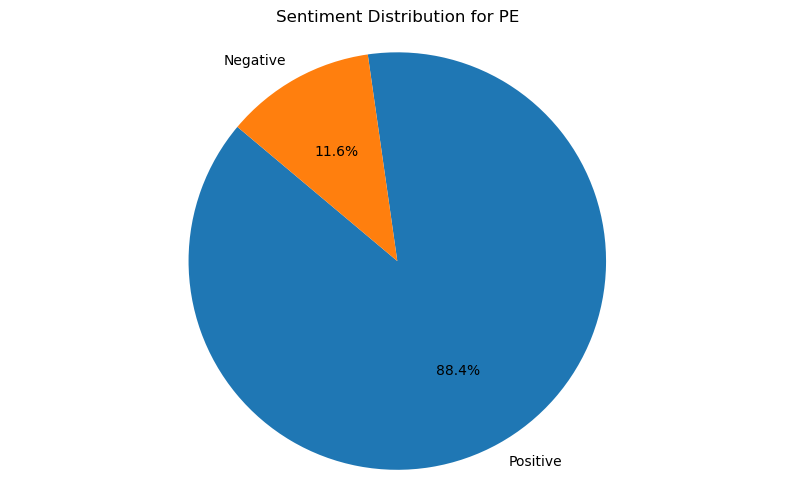

Entity: EBITDA
Total Positive Mentions: 19
Total Negative Mentions: 2
Overall Sentiment Score: 17



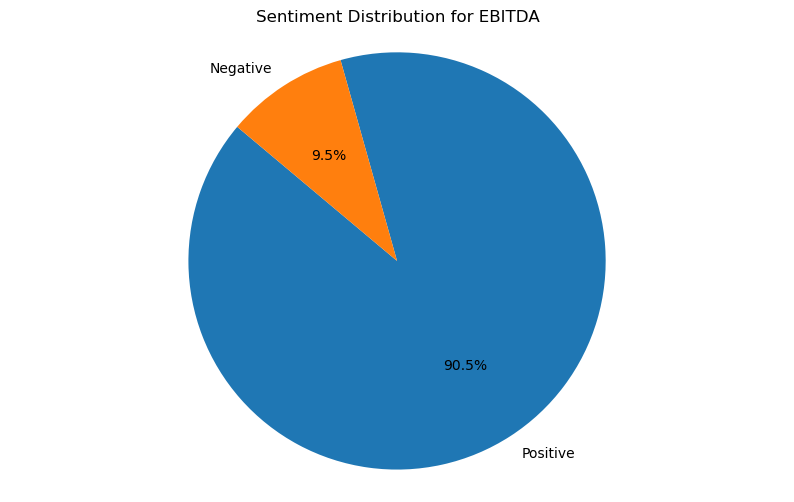

Entity: VOO
Total Positive Mentions: 70
Total Negative Mentions: 5
Overall Sentiment Score: 65



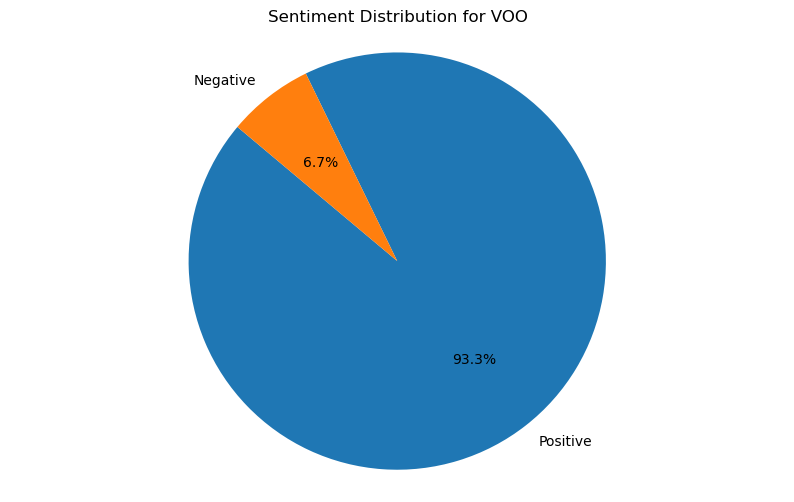

Entity: SPY
Total Positive Mentions: 68
Total Negative Mentions: 10
Overall Sentiment Score: 58



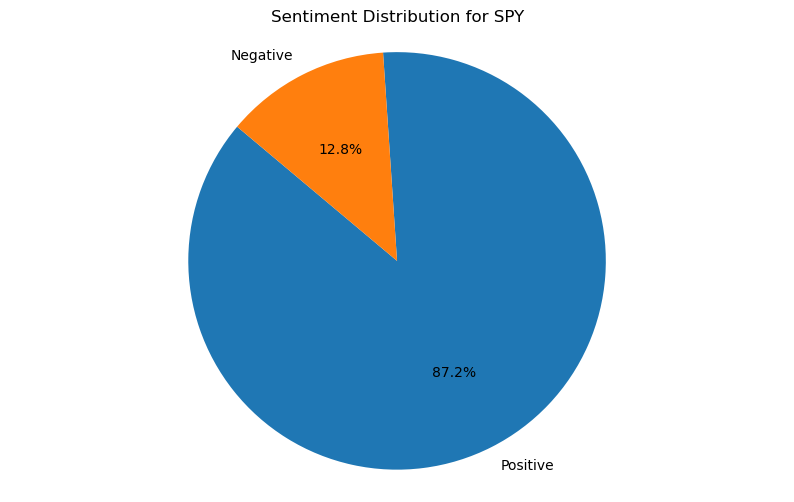

In [315]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV into Pandas DataFrames
data_PE = pd.read_csv('PE_data.csv')
data_EBITDA = pd.read_csv('EBITDA_data.csv')
data_VOO = pd.read_csv('VOO_data.csv')
data_SPY = pd.read_csv('SPY_data.csv')

def analyze_sentiment(data, entity_name):
    # Group by 'Sentiment' and sum all columns
    data_grouped = data.groupby('Sentiment').sum()
    
    # Calculate total sentiments
    total_positive = data_grouped.loc['Positive', 'Subreddit'] if 'Positive' in data_grouped.index else 0
    total_negative = data_grouped.loc['Negative', 'Subreddit'] if 'Negative' in data_grouped.index else 0
    
    # Print the analysis
    print(f"Entity: {entity_name}")
    print(f"Total Positive Mentions: {total_positive}")
    print(f"Total Negative Mentions: {total_negative}")
    print(f"Overall Sentiment Score: {total_positive - total_negative}")
    print()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    labels = ['Positive', 'Negative']
    sizes = [total_positive, total_negative]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Sentiment Distribution for {entity_name}')
    plt.show()

# Analyze sentiment for each entity
analyze_sentiment(data_PE, 'PE')
analyze_sentiment(data_EBITDA, 'EBITDA')
analyze_sentiment(data_VOO, 'VOO')
analyze_sentiment(data_SPY, 'SPY')


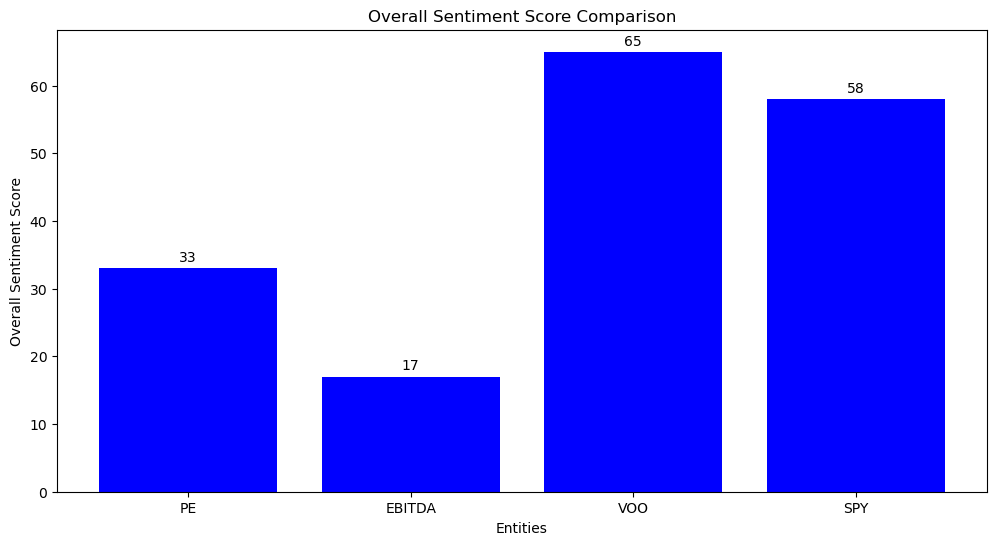

Comparing PE and EBITDA:
PE has a sentiment score of 33.
EBITDA has a sentiment score of 17.
PE has a more positive sentiment than EBITDA by 16 points.

Comparing PE and VOO:
PE has a sentiment score of 33.
VOO has a sentiment score of 65.
VOO has a more positive sentiment than PE by 32 points.

Comparing PE and SPY:
PE has a sentiment score of 33.
SPY has a sentiment score of 58.
SPY has a more positive sentiment than PE by 25 points.

Comparing EBITDA and VOO:
EBITDA has a sentiment score of 17.
VOO has a sentiment score of 65.
VOO has a more positive sentiment than EBITDA by 48 points.

Comparing EBITDA and SPY:
EBITDA has a sentiment score of 17.
SPY has a sentiment score of 58.
SPY has a more positive sentiment than EBITDA by 41 points.

Comparing VOO and SPY:
VOO has a sentiment score of 65.
SPY has a sentiment score of 58.
VOO has a more positive sentiment than SPY by 7 points.



In [316]:
import matplotlib.pyplot as plt
import numpy as np

# Sentimental scores for each entity
sentiment_scores = {
    'PE': 33,
    'EBITDA': 17,
    'VOO': 65,
    'SPY': 58
}

# Names of the entities
entity_names = list(sentiment_scores.keys())

# Corresponding sentiment scores
scores = list(sentiment_scores.values())

# Plotting the overall sentiment score for each entity
plt.figure(figsize=(12, 6))
plt.bar(entity_names, scores, color='b')
plt.xlabel('Entities')
plt.ylabel('Overall Sentiment Score')
plt.title('Overall Sentiment Score Comparison')
for i, v in enumerate(scores):
    plt.text(i, v + 1, str(v), ha='center')
plt.show()

# Comparing sentiment between each pair of entities
for i in range(len(entity_names)):
    for j in range(i + 1, len(entity_names)):
        entity1 = entity_names[i]
        entity2 = entity_names[j]
        
        score1 = sentiment_scores[entity1]
        score2 = sentiment_scores[entity2]
        
        print(f"Comparing {entity1} and {entity2}:")
        print(f"{entity1} has a sentiment score of {score1}.")
        print(f"{entity2} has a sentiment score of {score2}.")
        
        diff = score1 - score2
        
        if diff > 0:
            print(f"{entity1} has a more positive sentiment than {entity2} by {abs(diff)} points.")
        elif diff < 0:
            print(f"{entity2} has a more positive sentiment than {entity1} by {abs(diff)} points.")
        else:
            print(f"{entity1} and {entity2} have the same sentiment score.")
        
        print()


In [1]:
pip install -U notebook-as-pdf

Note: you may need to restart the kernel to use updated packages.
